In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

In [3]:
def get_pbulks(ddir, files, ncond, nrep, nclst, ngene):
    """
    """
    pbulks = []
    xclsts = []
    xcnsts = []
    for f in files:
        print(f)

        path = os.path.join(ddir, f)
        adata = anndata.read(path)
        genes = adata.var.index.values

        # adata = adata[adata.obs['Subclass'] == 'L2/3']
        mat = adata.X
        types = adata.obs['Type'].astype(str).values 
        # 1 or 2
        sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
        sample_and_type = sample_codes + "_" + types
        unqs, cnts = np.unique(sample_and_type, return_counts=True)
        _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 

        # check all types + reps are the same
        if len(xclsts) > 0:
            if not np.all(_xclsts == xclsts):
                raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
            if not np.all(_xclsts == unqs):
                raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
        else:
            xclsts = _xclsts
            print(xclsts)

        pbulks.append(Xk_ln)
        xcnsts.append(cnts)

    pbulks = np.array(pbulks)
    xcnsts = np.array(xcnsts)
    
    pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
    xclsts = xclsts.reshape(      nrep,nclst)
    xcnsts = xcnsts.reshape(ncond,nrep,nclst)
    
    return pbulks, xcnsts, xclsts, genes

# get data

In [4]:
ddir = '../data/cheng21_cell_scrna/organized/'

In [5]:
files = [
    # 'P8NR.h5ad',
    
    # 'P14NR.h5ad',
    
    # 'P17NR.h5ad',
    # 'P21NR.h5ad',
    'P28NR.h5ad',
    # 'P38NR.h5ad',
    
    # 'P28DR.h5ad',
    # 'P38DR.h5ad',
    
    # 'P28DL.h5ad',
] 
# conds = np.array([f.replace('.h5ad', '') for f in files])

ncond, nrep, nclst, ngene = len(files), 2, 42, -1
pbulks_nr, xcnsts, xclsts, genes = get_pbulks(ddir, files, ncond, nrep, nclst, ngene)

xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

P28NR.h5ad
['1_Astro_A' '1_Astro_B' '1_Endo' '1_Frem1' '1_L2/3_A' '1_L2/3_B'
 '1_L2/3_C' '1_L4_A' '1_L4_B' '1_L4_C' '1_L5IT' '1_L5NP' '1_L5PT_A'
 '1_L5PT_B' '1_L6CT_A' '1_L6CT_B' '1_L6CT_C' '1_L6IT_A' '1_L6IT_B' '1_L6b'
 '1_Lamp5' '1_Micro' '1_OD_A' '1_OD_B' '1_OD_C' '1_OPC_A' '1_OPC_B'
 '1_Pvalb_A' '1_Pvalb_B' '1_Pvalb_C' '1_Pvalb_D' '1_Sst_A' '1_Sst_B'
 '1_Sst_C' '1_Sst_D' '1_Sst_E' '1_Stac' '1_VLMC_A' '1_VLMC_B' '1_Vip_A'
 '1_Vip_B' '1_Vip_C' '2_Astro_A' '2_Astro_B' '2_Endo' '2_Frem1' '2_L2/3_A'
 '2_L2/3_B' '2_L2/3_C' '2_L4_A' '2_L4_B' '2_L4_C' '2_L5IT' '2_L5NP'
 '2_L5PT_A' '2_L5PT_B' '2_L6CT_A' '2_L6CT_B' '2_L6CT_C' '2_L6IT_A'
 '2_L6IT_B' '2_L6b' '2_Lamp5' '2_Micro' '2_OD_A' '2_OD_B' '2_OD_C'
 '2_OPC_A' '2_OPC_B' '2_Pvalb_A' '2_Pvalb_B' '2_Pvalb_C' '2_Pvalb_D'
 '2_Sst_A' '2_Sst_B' '2_Sst_C' '2_Sst_D' '2_Sst_E' '2_Stac' '2_VLMC_A'
 '2_VLMC_B' '2_Vip_A' '2_Vip_B' '2_Vip_C']


0     1
Astro_A   754   979
Astro_B   167   268
Endo      138   287
Frem1      39    60
L2/3_A    296   316
L2/3_B   1218  1164
L2/3_C    557   493
L4_A      993   952
L4_B     1028  1001
L4_C      408   350
L5IT      386   463
L5NP      153   242
L5PT_A    298   316
L5PT_B     47    47
L6CT_A    106   106
L6CT_B    749   827
L6CT_C    514   613
L6IT_A    521   660
L6IT_B    150   105
L6b        95   141
Lamp5      98   125
Micro     427   721
OD_A      135   217
OD_B      397   606
OD_C       82   108
OPC_A     317   562
OPC_B      16    58
Pvalb_A   110   145
Pvalb_B    99   136
Pvalb_C    56    66
Pvalb_D    84    93
Sst_A      87    90
Sst_B      47    60
Sst_C      88    91
Sst_D      30    48
Sst_E      26    27
Stac       11    31
VLMC_A     39    63
VLMC_B     47   121
Vip_A      60    79
Vip_B      52    76
Vip_C      48    44

In [6]:
pbulks_nr.shape 

(1, 2, 42, 53801)

# check microglia

In [7]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
# df = df[df['why included'].str.contains('All cell types') & 
#         df['source'].str.contains('analysis')
#        ]
df = df[df['why included'].str.contains('Microglia')
        # & df['source'].str.contains('analysis')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

60 (60,) [] []


In [8]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

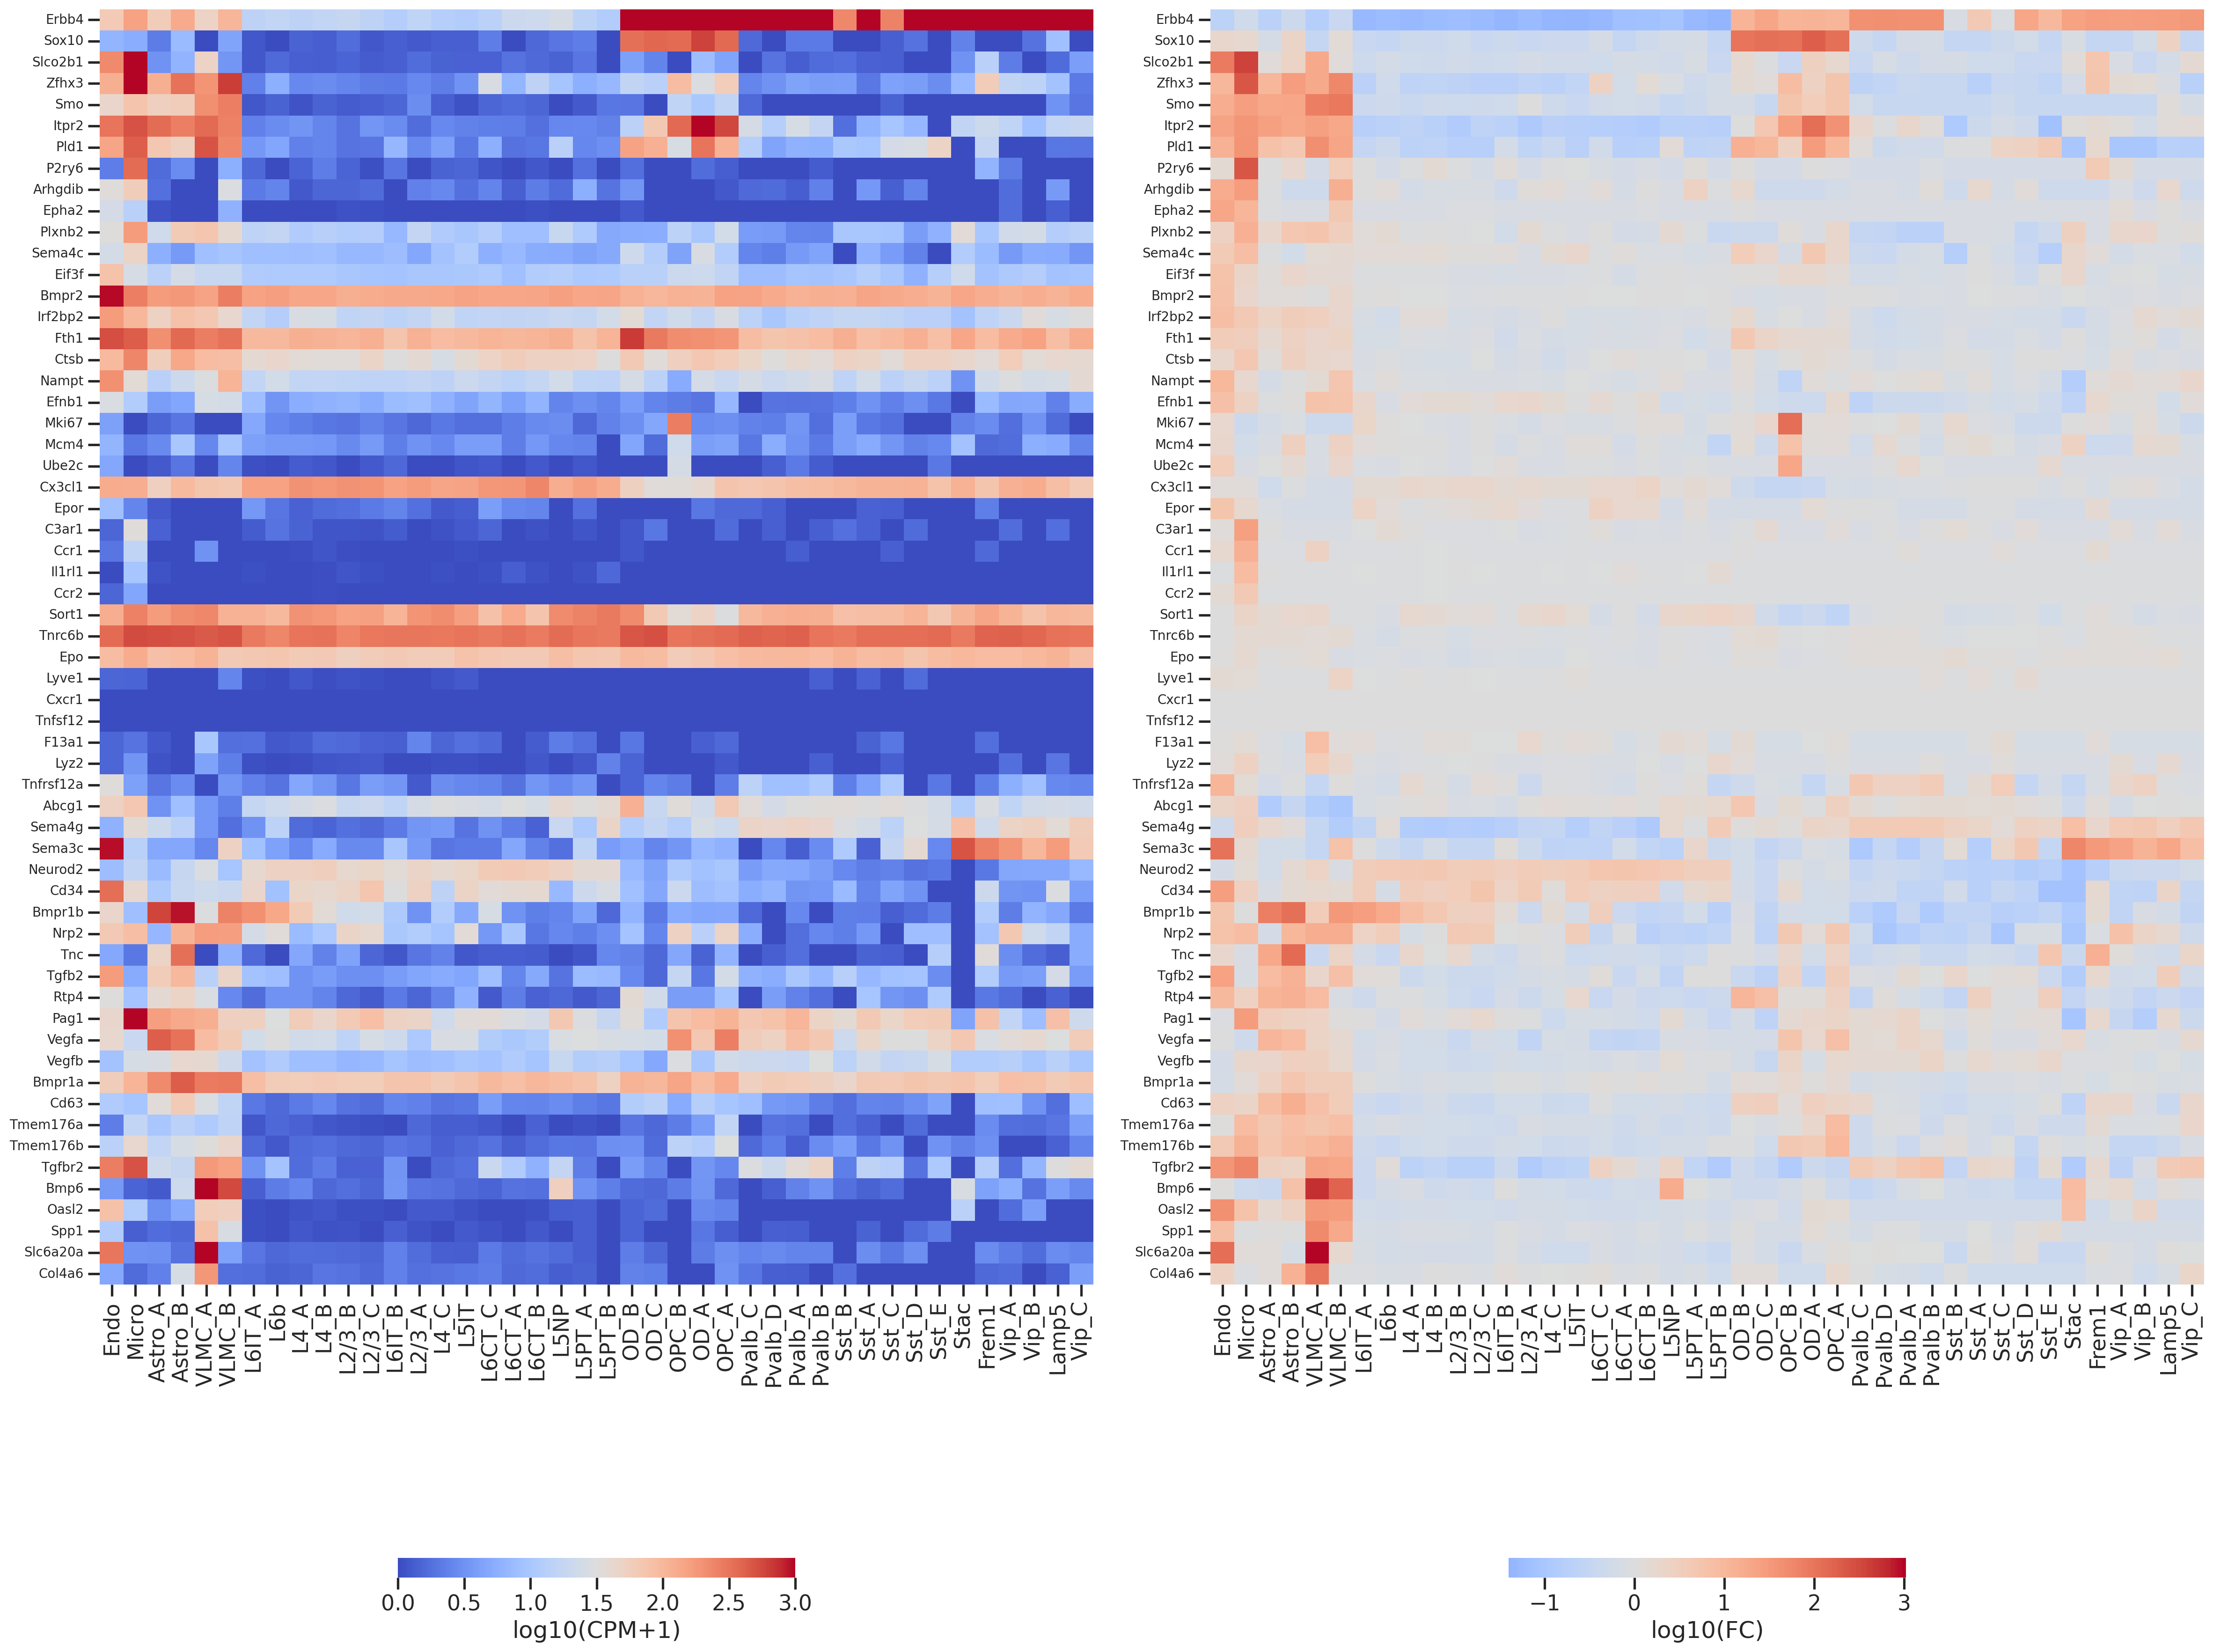

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    vmax=3,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

In [47]:
genes_sub = np.array([
    # 'Neurod2', 'Erbb4', 
    'Sox10', 'Itpr2', 
    'Mog', 'Pdgfa',
    'Zfhx4', 'Gm28836',
    # 'Pcp4', 'Actb', 'Pam', 'Slc24a2',
    #   'Slc17a7', 
    #   'Lamp5', 'Sst', 'Pvalb', 'Vip', 'Gad1',
    #   'Snap25',
    #                   # '2310002F09Rik',
    #                   # 'Otx1',
    #                   # 'Hcn1',
    # 'Fth1',
    # 'Itpr2',
    # 'Eif3f',
    #                   'Rgs4',
    #                   'Pcp4',
    #                   'Hs3st2',
    #                   'Tmsb10',
    #                   'Il1rl1',
    # 'Actb',
    # 'Pam',
                     ])
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
print(gidx_sub)

exp_sub = np.mean(pbulks_nr[:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
rowidx_sub = basicu.order_by_hc(lfc_sub)
colidx_sub = basicu.order_by_hc(lfc_sub.T)

[46360 21922 49395 18522  9887   281]


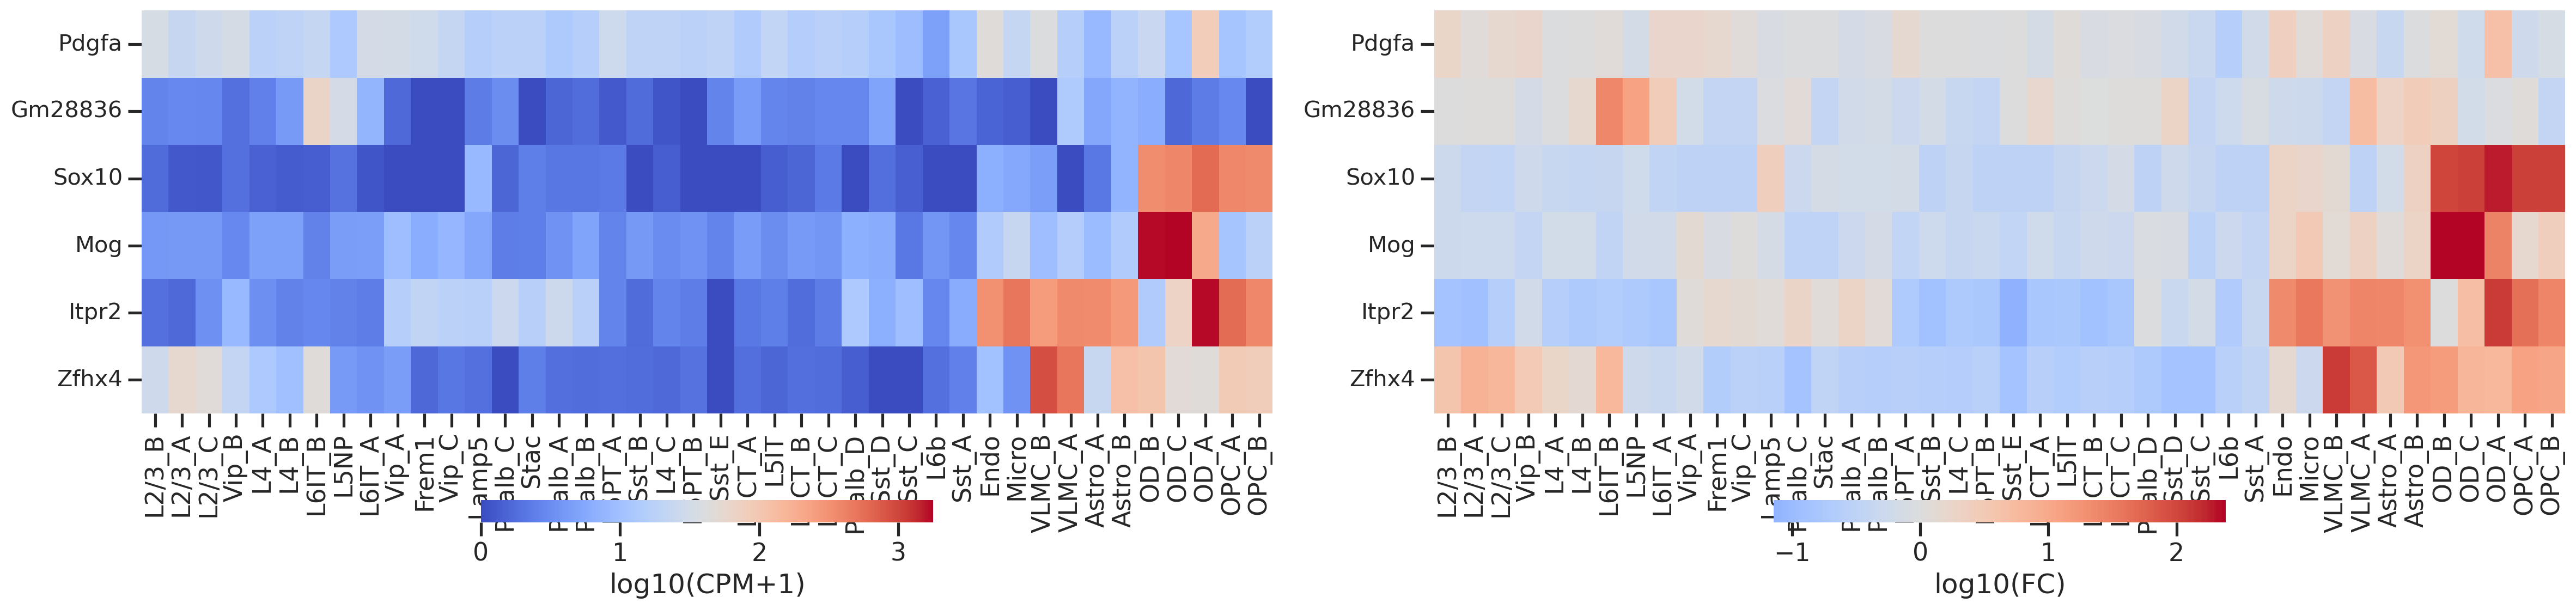

In [48]:
fig, axs = plt.subplots(1,2,figsize=(12*2,6))
ax = axs[0]
sns.heatmap(
    exp_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

ax = axs[1]
sns.heatmap(
    lfc_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)
fig.tight_layout()
plt.show()

In [12]:
genes_sub = np.array(
['Cntnap2', 'Kcnq5', 'Rbfox1', 'Negr1', 'Lrrtm4', 'Ntm', 'Nlgn1',
       'Ralyl', 'Kctd16', 'Fam19a1', 'Dab1', 'Hs6st3', 'Nrg1', 'Lrp1b',
       'Nrxn1']
                     )
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
print(gidx_sub)

exp_sub = np.mean(pbulks_nr[:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
rowidx_sub = basicu.order_by_hc(lfc_sub)
colidx_sub = basicu.order_by_hc(lfc_sub.T)

[19582   293 47201 12707 20416 34913 10110  9981 52124 20842 14149 34351
 30014  4456 50078]


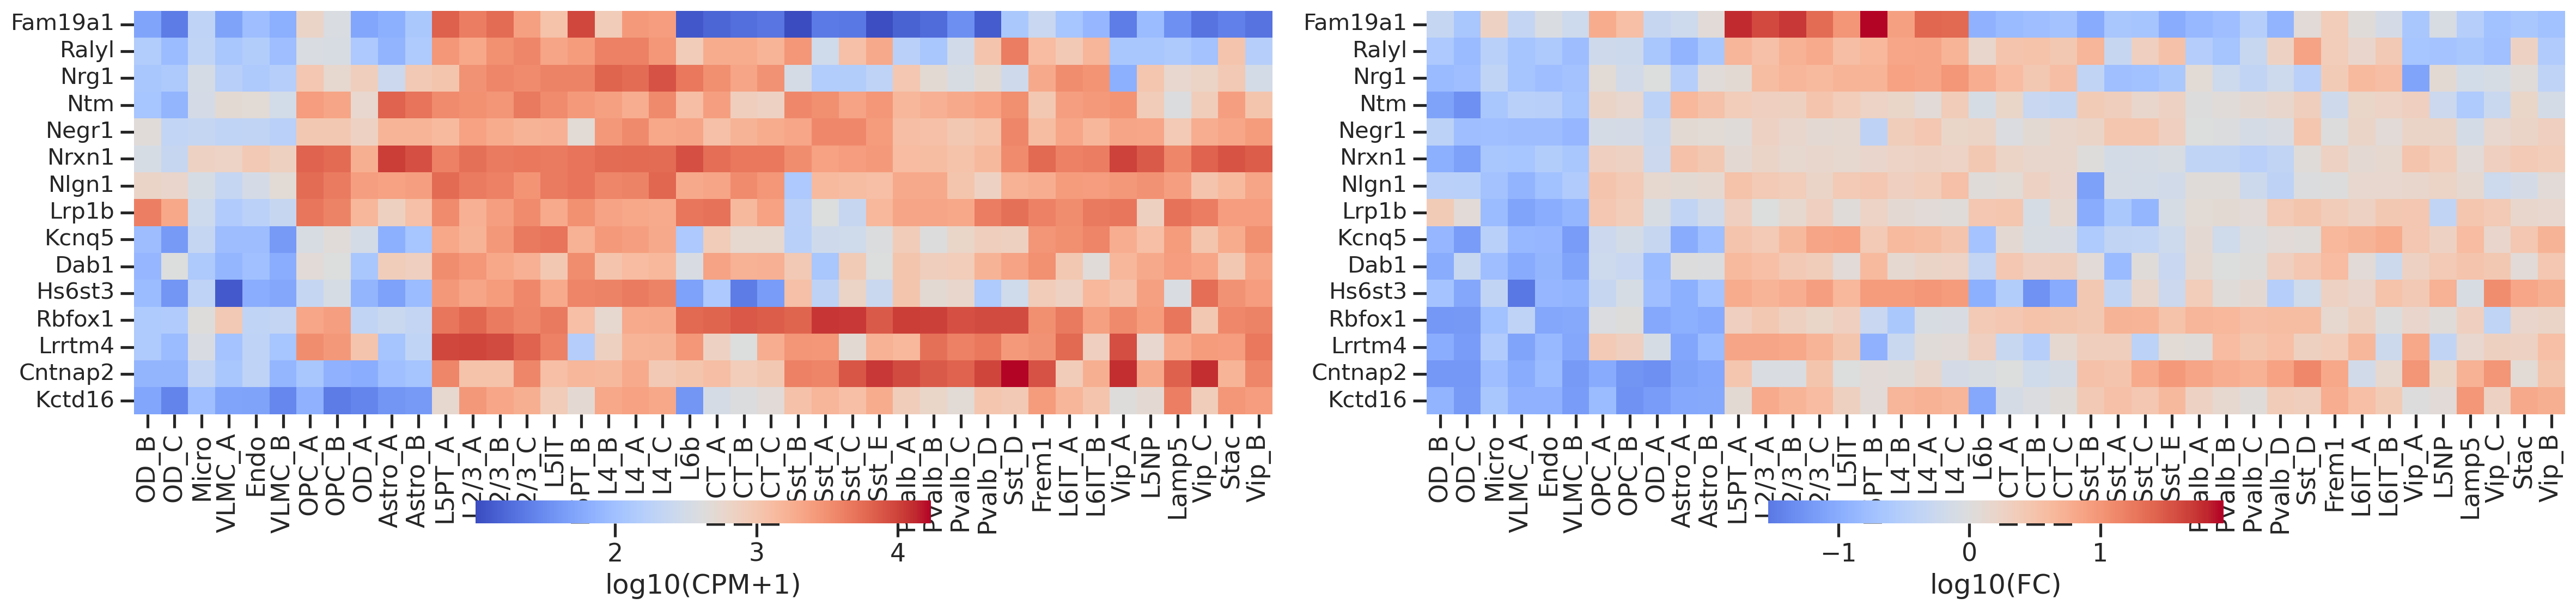

In [13]:
fig, axs = plt.subplots(1,2,figsize=(12*2,6))
ax = axs[0]
sns.heatmap(
    exp_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

ax = axs[1]
sns.heatmap(
    lfc_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)
fig.tight_layout()
plt.show()

In [64]:
genes_sub = np.array([
    'Pcp4', 'Apoe', 'Aldoc', 'Itm2c',
])
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
print(gidx_sub)

exp_sub = np.mean(pbulks_nr[:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
rowidx_sub = basicu.order_by_hc(lfc_sub)
colidx_sub = basicu.order_by_hc(lfc_sub.T)

[48358 22815 38931  1438]


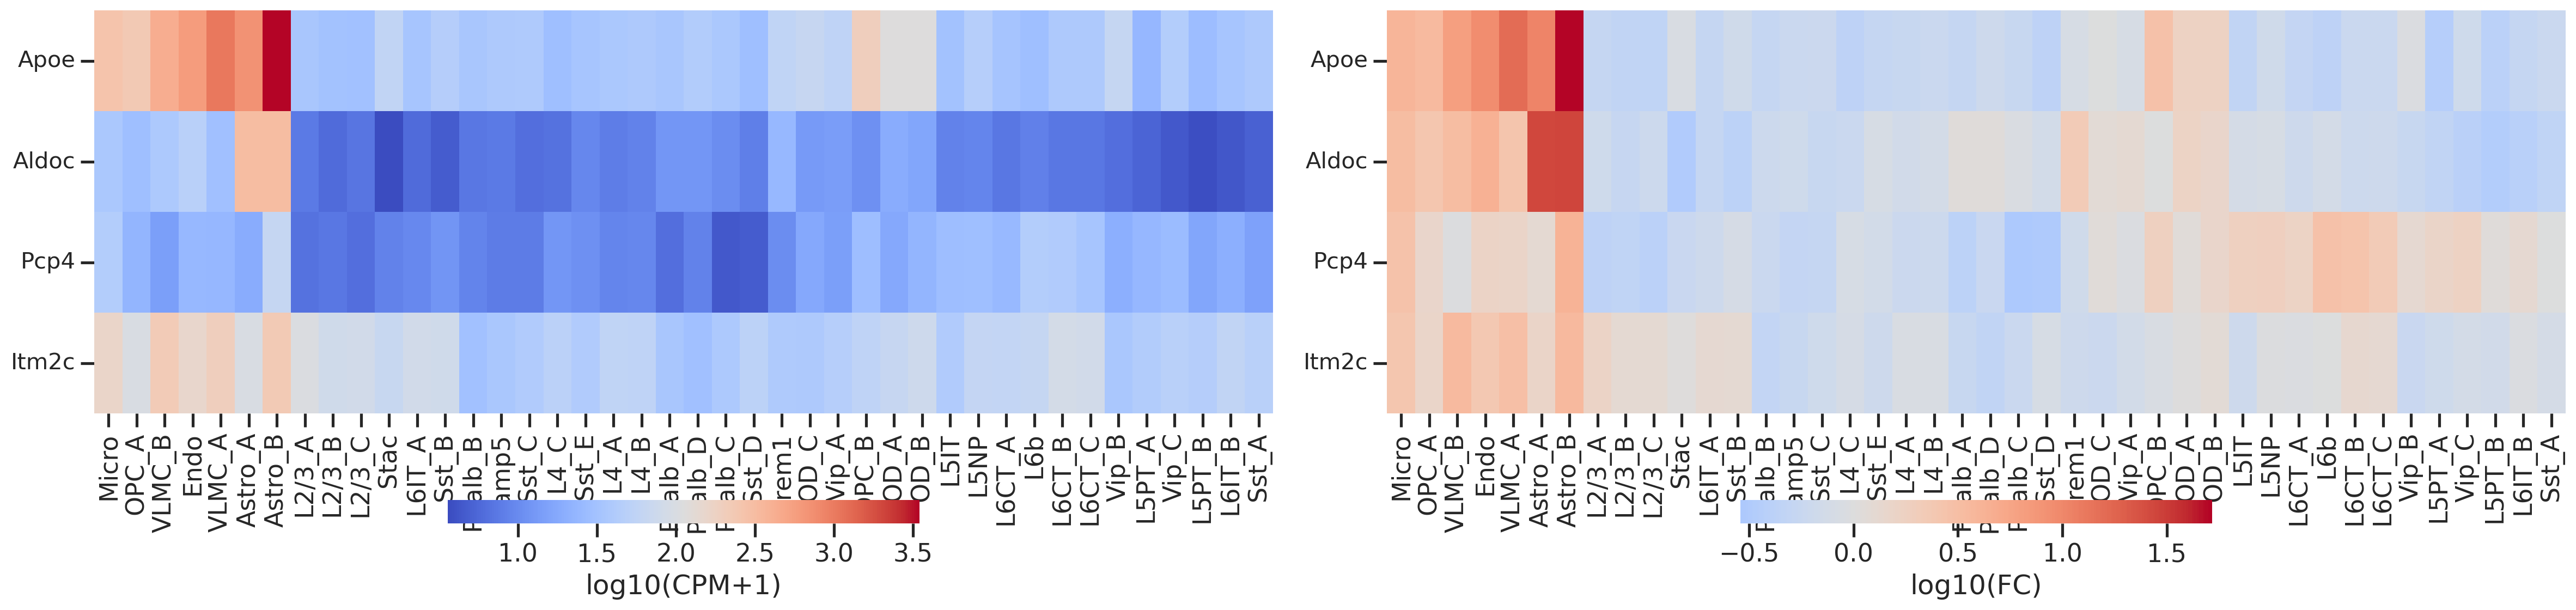

In [65]:
fig, axs = plt.subplots(1,2,figsize=(12*2,6))
ax = axs[0]
sns.heatmap(
    exp_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

ax = axs[1]
sns.heatmap(
    lfc_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)
fig.tight_layout()
plt.show()

In [50]:
f = "../results/MERFISH_gene_panel_Working_Mar9.csv"
df = pd.read_csv(f)
df = df[df['Annot1'].fillna('').str.contains('L4 C')]
df.shape

(43, 16)

In [56]:
cidx = basicu.get_index_from_array(xclsts_short, ['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C', 'L5IT'])
cidx

array([ 4,  5,  6,  7,  8,  9, 10])

In [62]:
genes_sub = df['gene_name_data'].values
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
print(gidx_sub)

exp_sub = np.mean(pbulks_nr[:,:,cidx,:][:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
rowidx_sub = basicu.order_by_hc(lfc_sub)
colidx_sub = basicu.order_by_hc(lfc_sub.T)

[ 9339 20750 42371  1883 39951 30385 49855 45878 35961 21414  3313  7871
 10297 16558 16322  8294 45480 32443 20416 14457 20802 27145 43414 14530
 35939 38173 13048  8349 40589 52770 34913 14281 32114 48095 10110 52174
 20816 12479 11872 24901 22032 29612  8115]


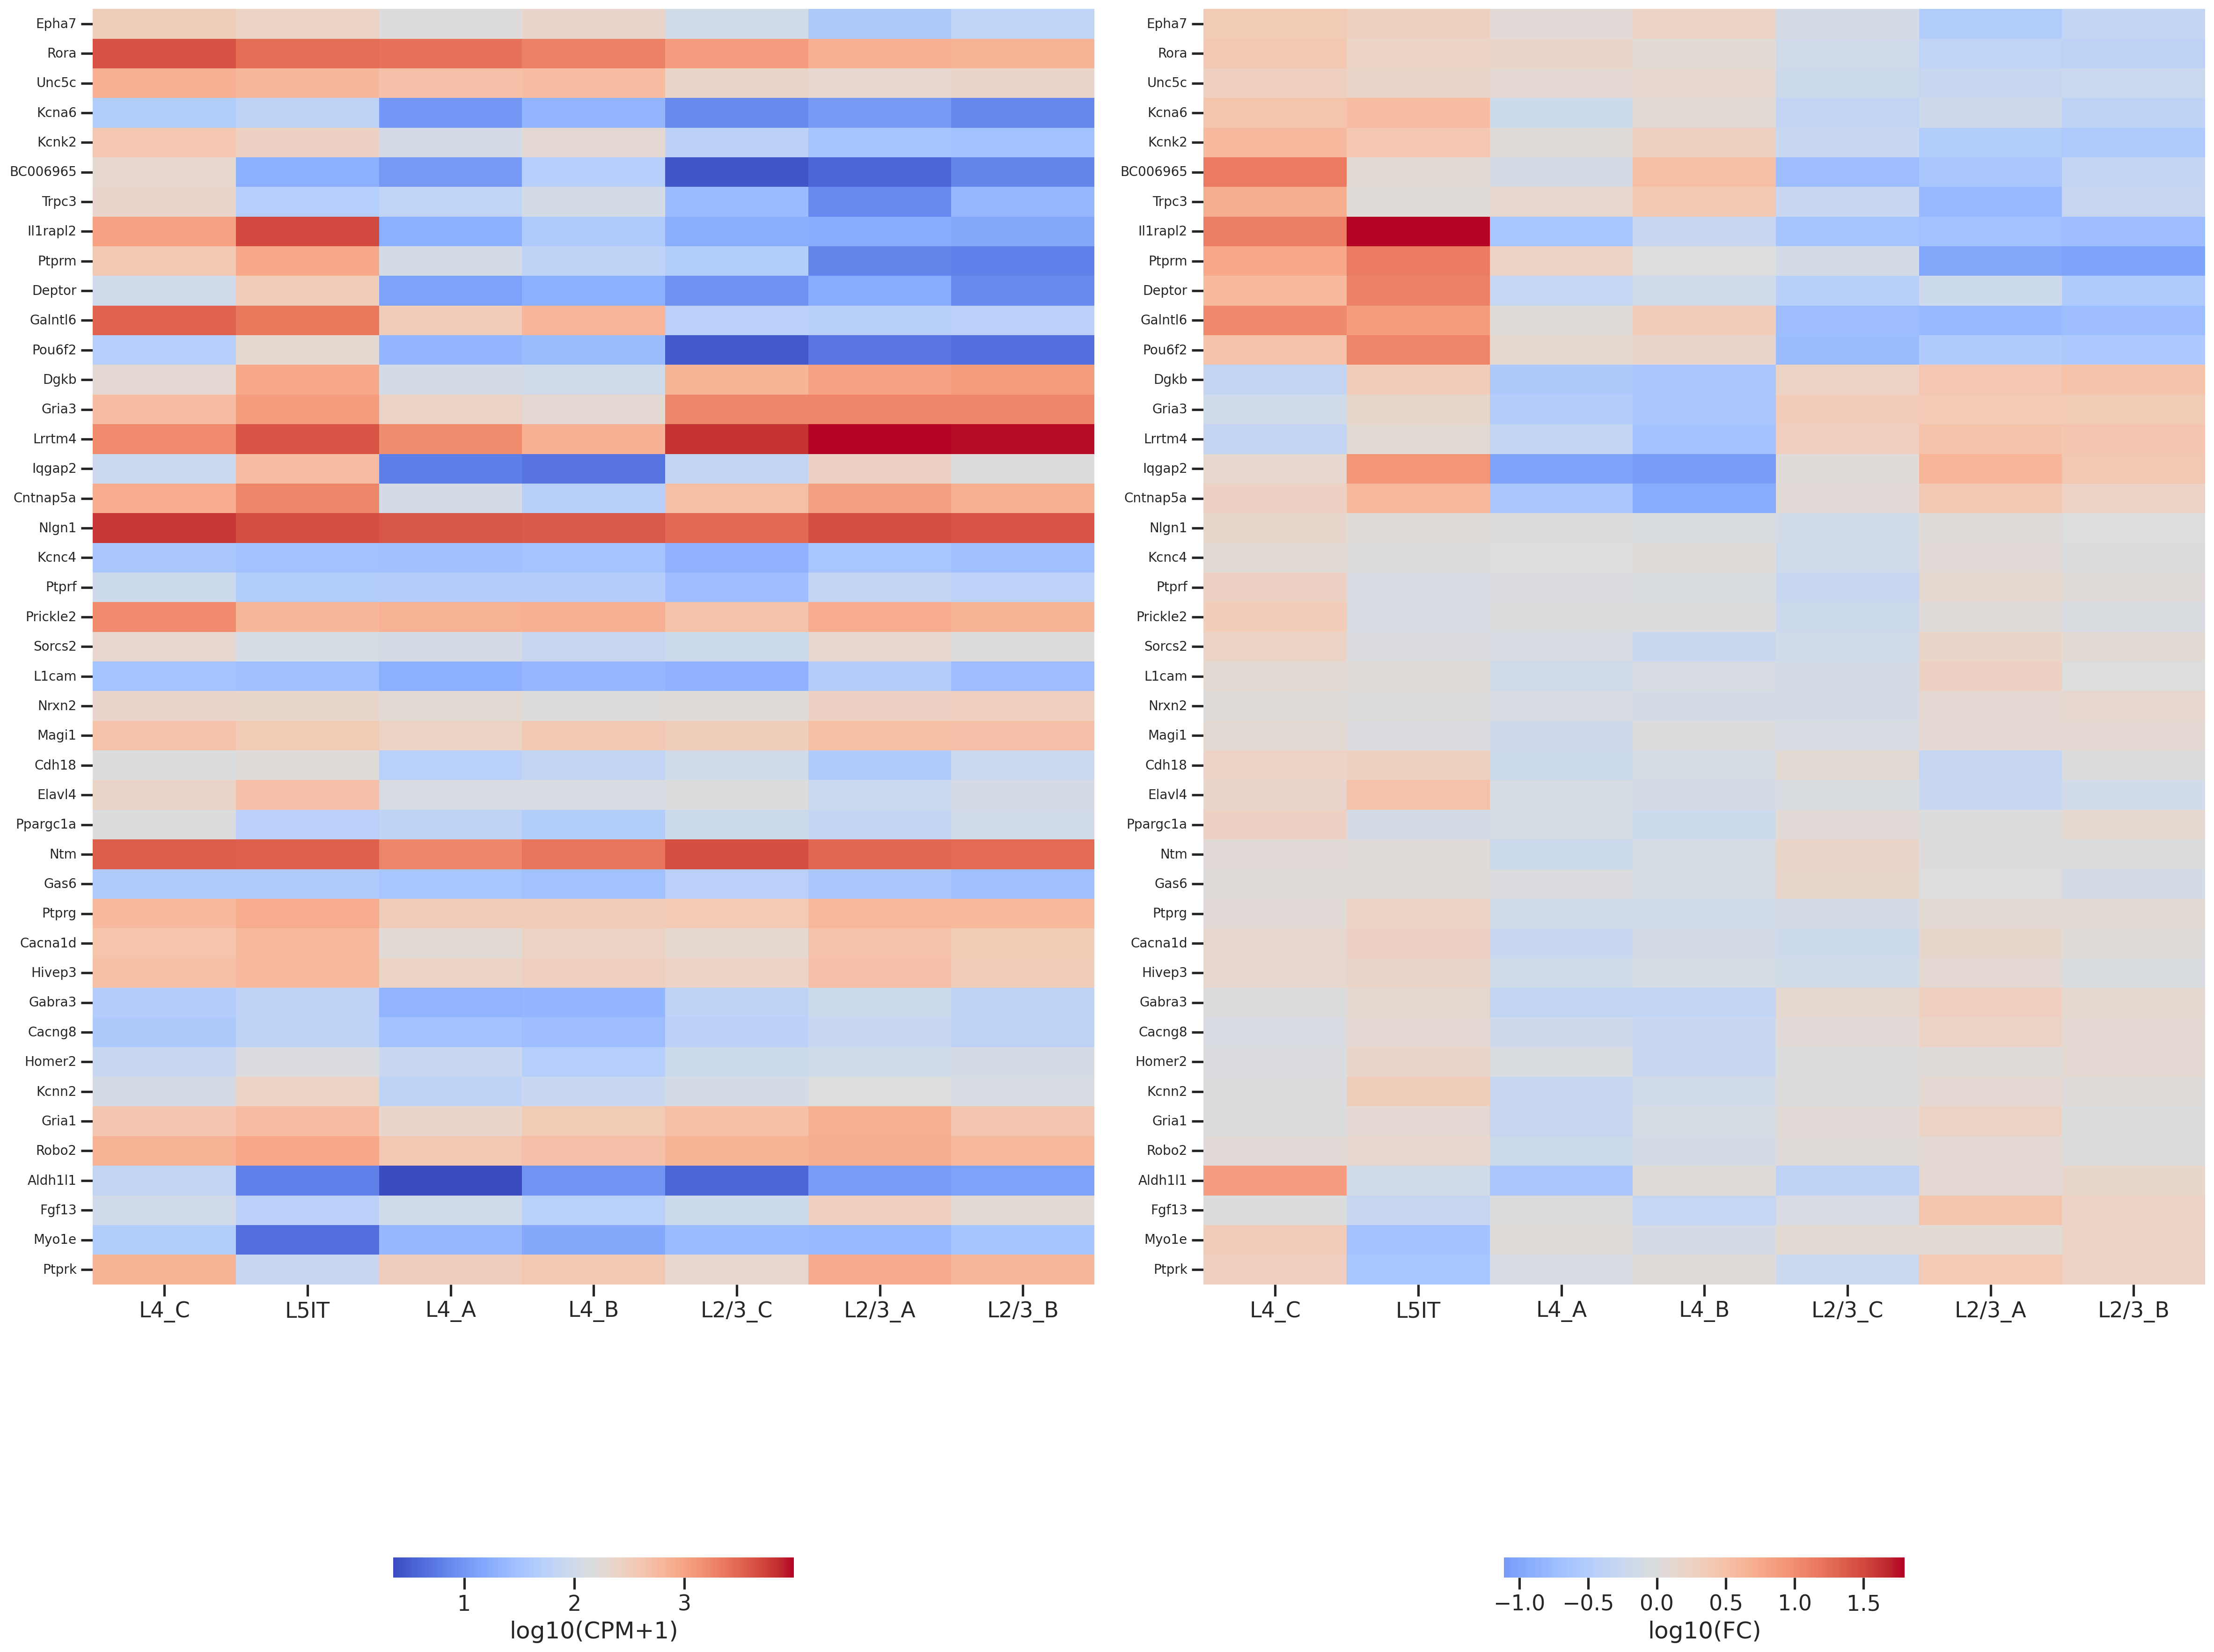

In [63]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[cidx][colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
# ax.axvline(7)
# ax.axvline(10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc_sub[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub[rowidx_sub],
    xticklabels=xclsts_short[cidx][colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.axvline(7)
# ax.axvline(10)
fig.tight_layout()
plt.show()

In [26]:
f = "../results/MERFISH_gene_panel_Working_Mar9.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('L2/3 types')]
df.shape

(170, 16)

In [27]:
genes_sub = df['gene_name_data'].values
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
print(gidx_sub)

exp_sub = np.mean(pbulks_nr[:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
# rowidx_sub = basicu.order_by_hc(lfc_sub)
# colidx_sub = basicu.order_by_hc(lfc_sub.T)

[45612 10150  4664 24608 16455 38009 31587 12084 38996 19050 34315 12072
  3710 30759 48240 48995 48823 38041 46697  9196  1124 11189 48093 53210
 25930 34515 52199  7886 16130 53206 45868 13819 21111 31043 52236 10955
 43570 47838 26841 24226 35442 48047 39967  5768 15043 12197 34990 15931
 44471 21882 19159 48066 15697  6017  7156 10901 11113 34505  2256 24159
  5639 18666 31876 52662 53562 43604 46588 27897 11995 10502 16840 35075
 12895  3056 14670 17204 12805 48156 19582 11958  1782 19971 20869 21413
   634 19329 53135 38454 31554 53123 29865 46123 43945 33783 13674 48243
 47953 13960 16581  4909  2151 39648 52541  1749 53099  4643  4683 13706
 14656  5959 45469 12284 33753 52559 35256 28541 34902   293 51710  2403
 42120 44193 42371  1135  4685  5729  6310 12908 26816 34129 42423 43535
 46732 47646 47999 52304 20842 26073 36686 11999 49532  2015  4935 18400
 19127 19709 27899 39879 12412  2507  3830 12969 13553 17385 17678 20686
 47400  8734 48943  5462 49515 46565 18252 13425 46

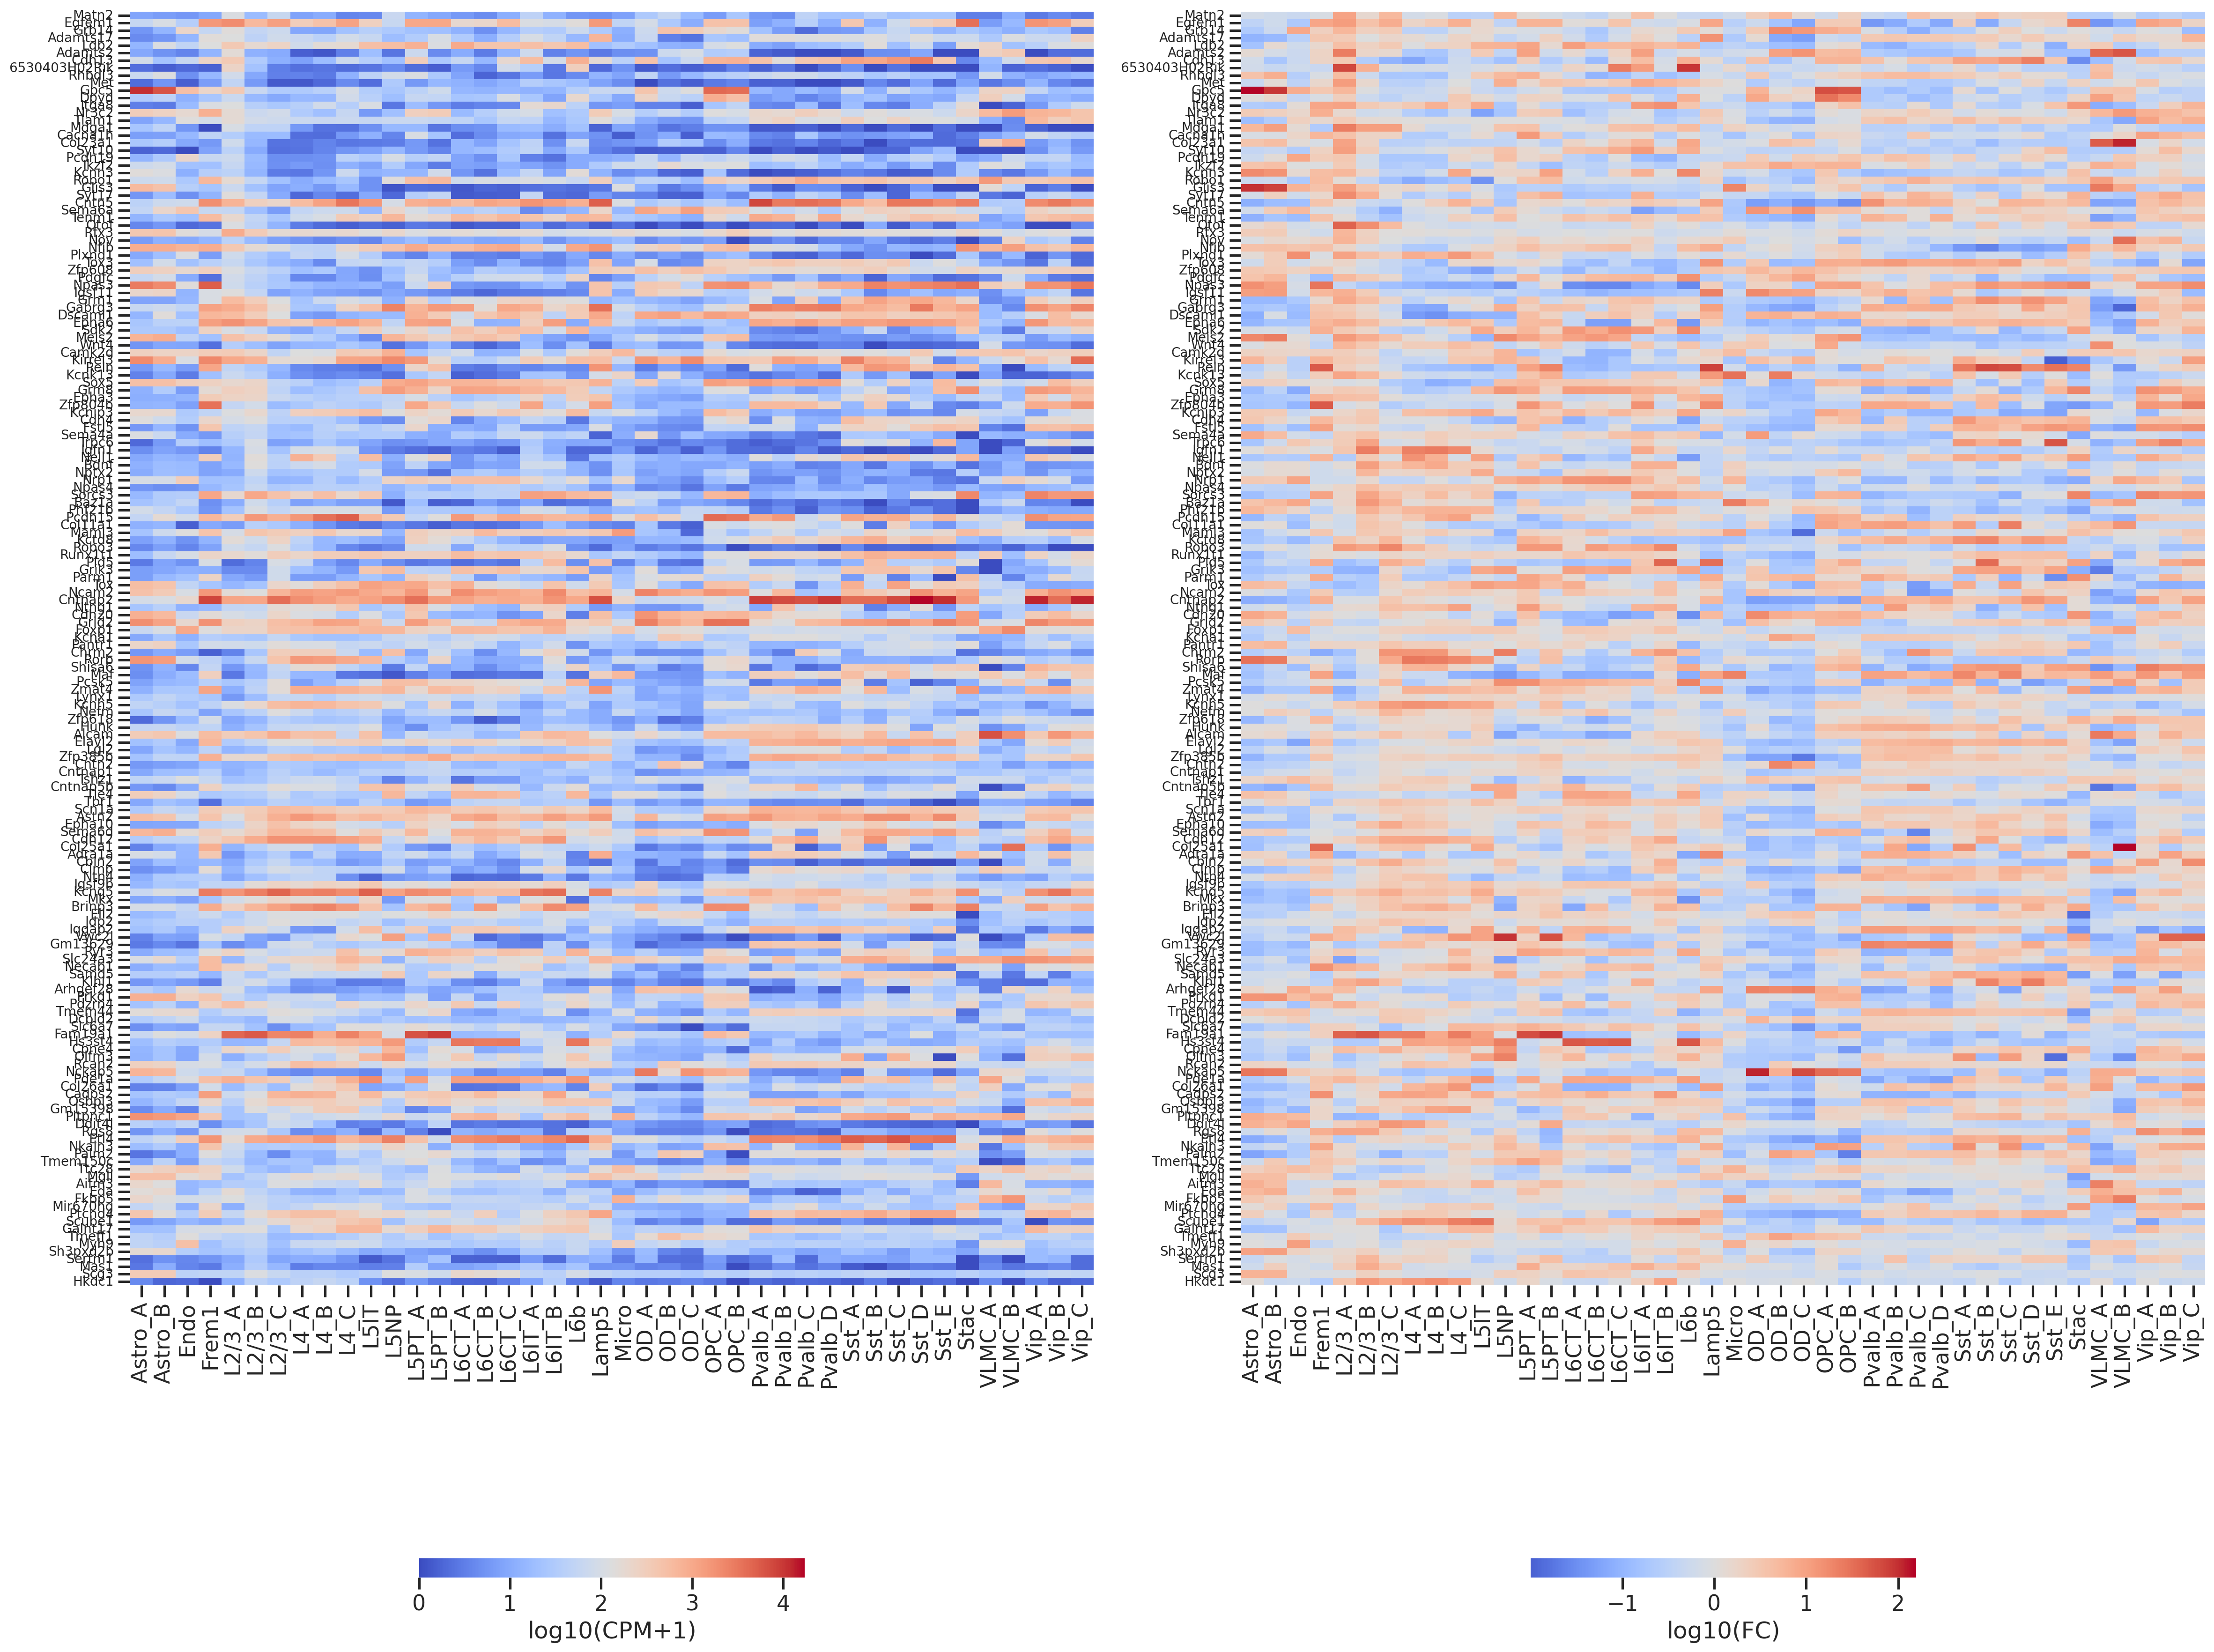

In [28]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp_sub,#[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub,#[rowidx_sub],
    xticklabels=xclsts_short,#[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc_sub,#[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub,#[rowidx_sub],
    xticklabels=xclsts_short,#[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

In [32]:
f = "../results/MERFISH_gene_panel_Working_Mar9.csv"
df = pd.read_csv(f)
# df = df[df['why included'].str.contains('L2/3 types')]
df.shape

(506, 16)

In [35]:
genes_sub = df['gene_name_data'].values
gidx_sub = basicu.get_index_from_array(genes, genes_sub)
# print(gidx_sub)
assert np.all(gidx_sub!=-1)

exp_sub = np.mean(pbulks_nr[:,:,:,gidx_sub], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc_sub = exp_sub - np.mean(exp_sub, axis=1).reshape(-1,1)
# rowidx_sub = basicu.order_by_hc(lfc_sub)
# colidx_sub = basicu.order_by_hc(lfc_sub.T)

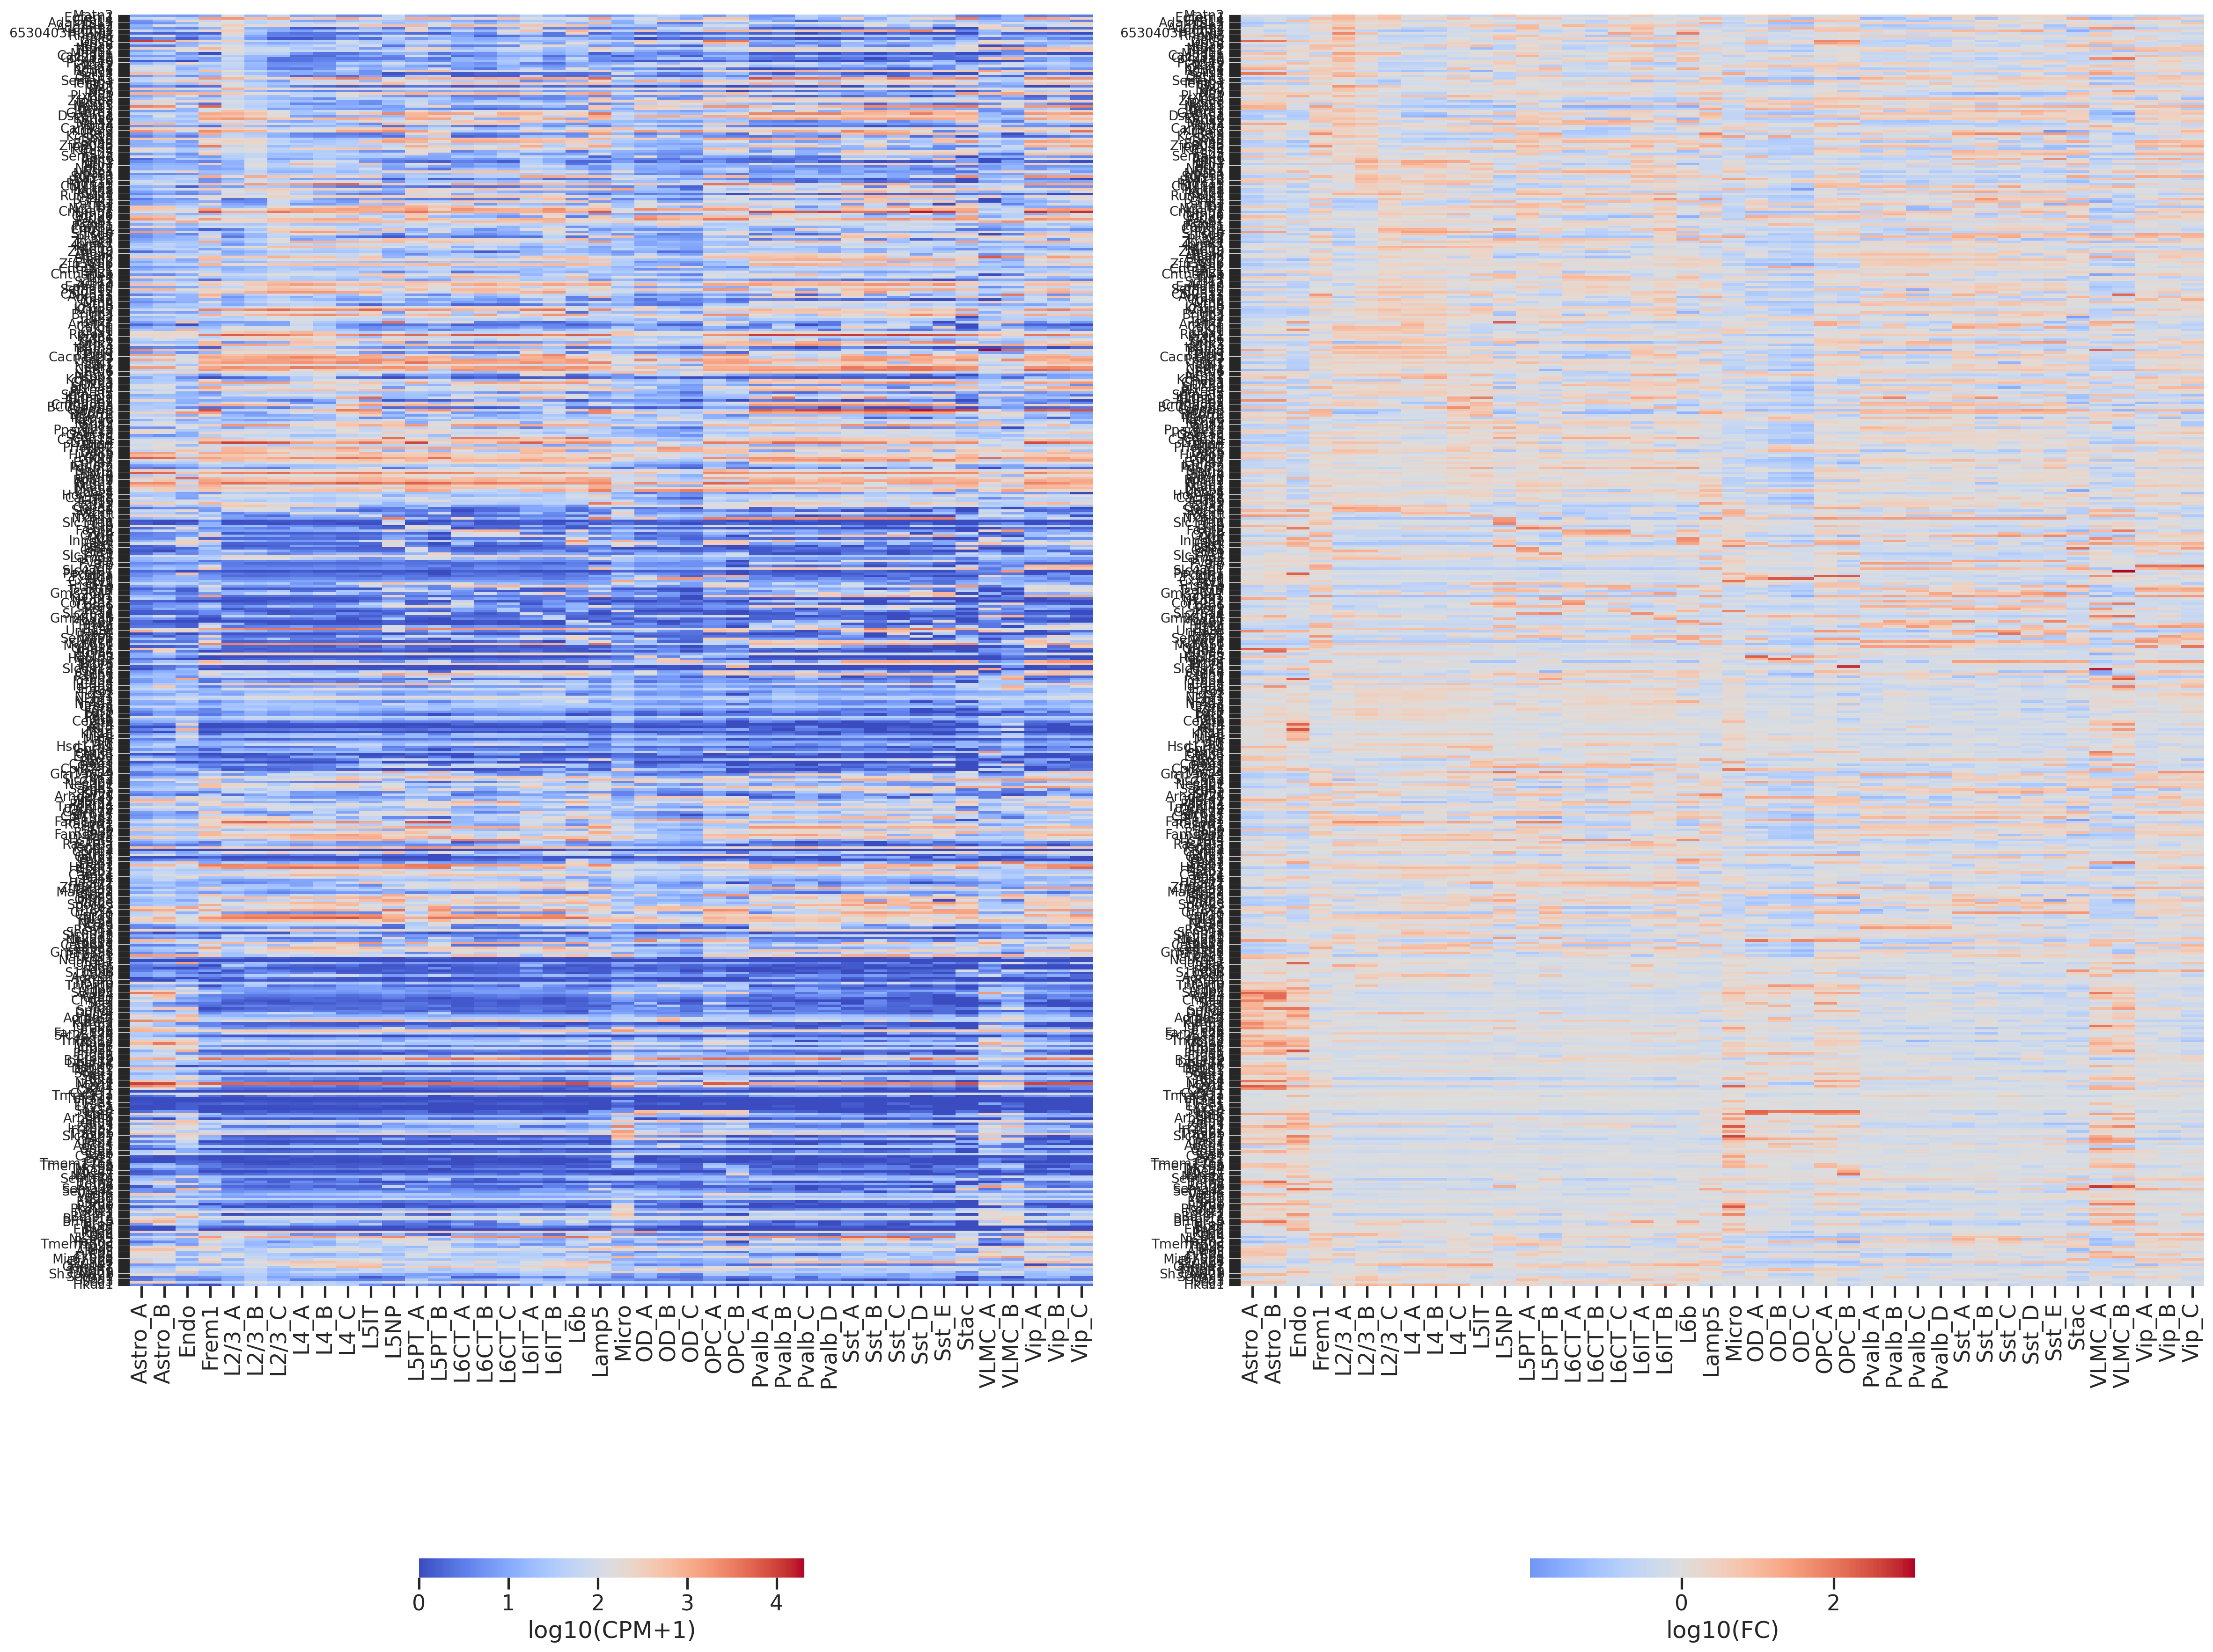

In [36]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp_sub,#[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub,#[rowidx_sub],
    xticklabels=xclsts_short,#[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc_sub,#[rowidx_sub,:][:,colidx_sub],
    yticklabels=genes_sub,#[rowidx_sub],
    xticklabels=xclsts_short,#[colidx_sub],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# Astrocytes

In [14]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
# df = df[df['why included'].str.contains('All cell types') & 
#         df['source'].str.contains('analysis')
#        ]
df = df[df['why included'].str.contains('Astrocytes')
        # & df['source'].str.contains('analysis')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

44 (44,) [] []


In [15]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

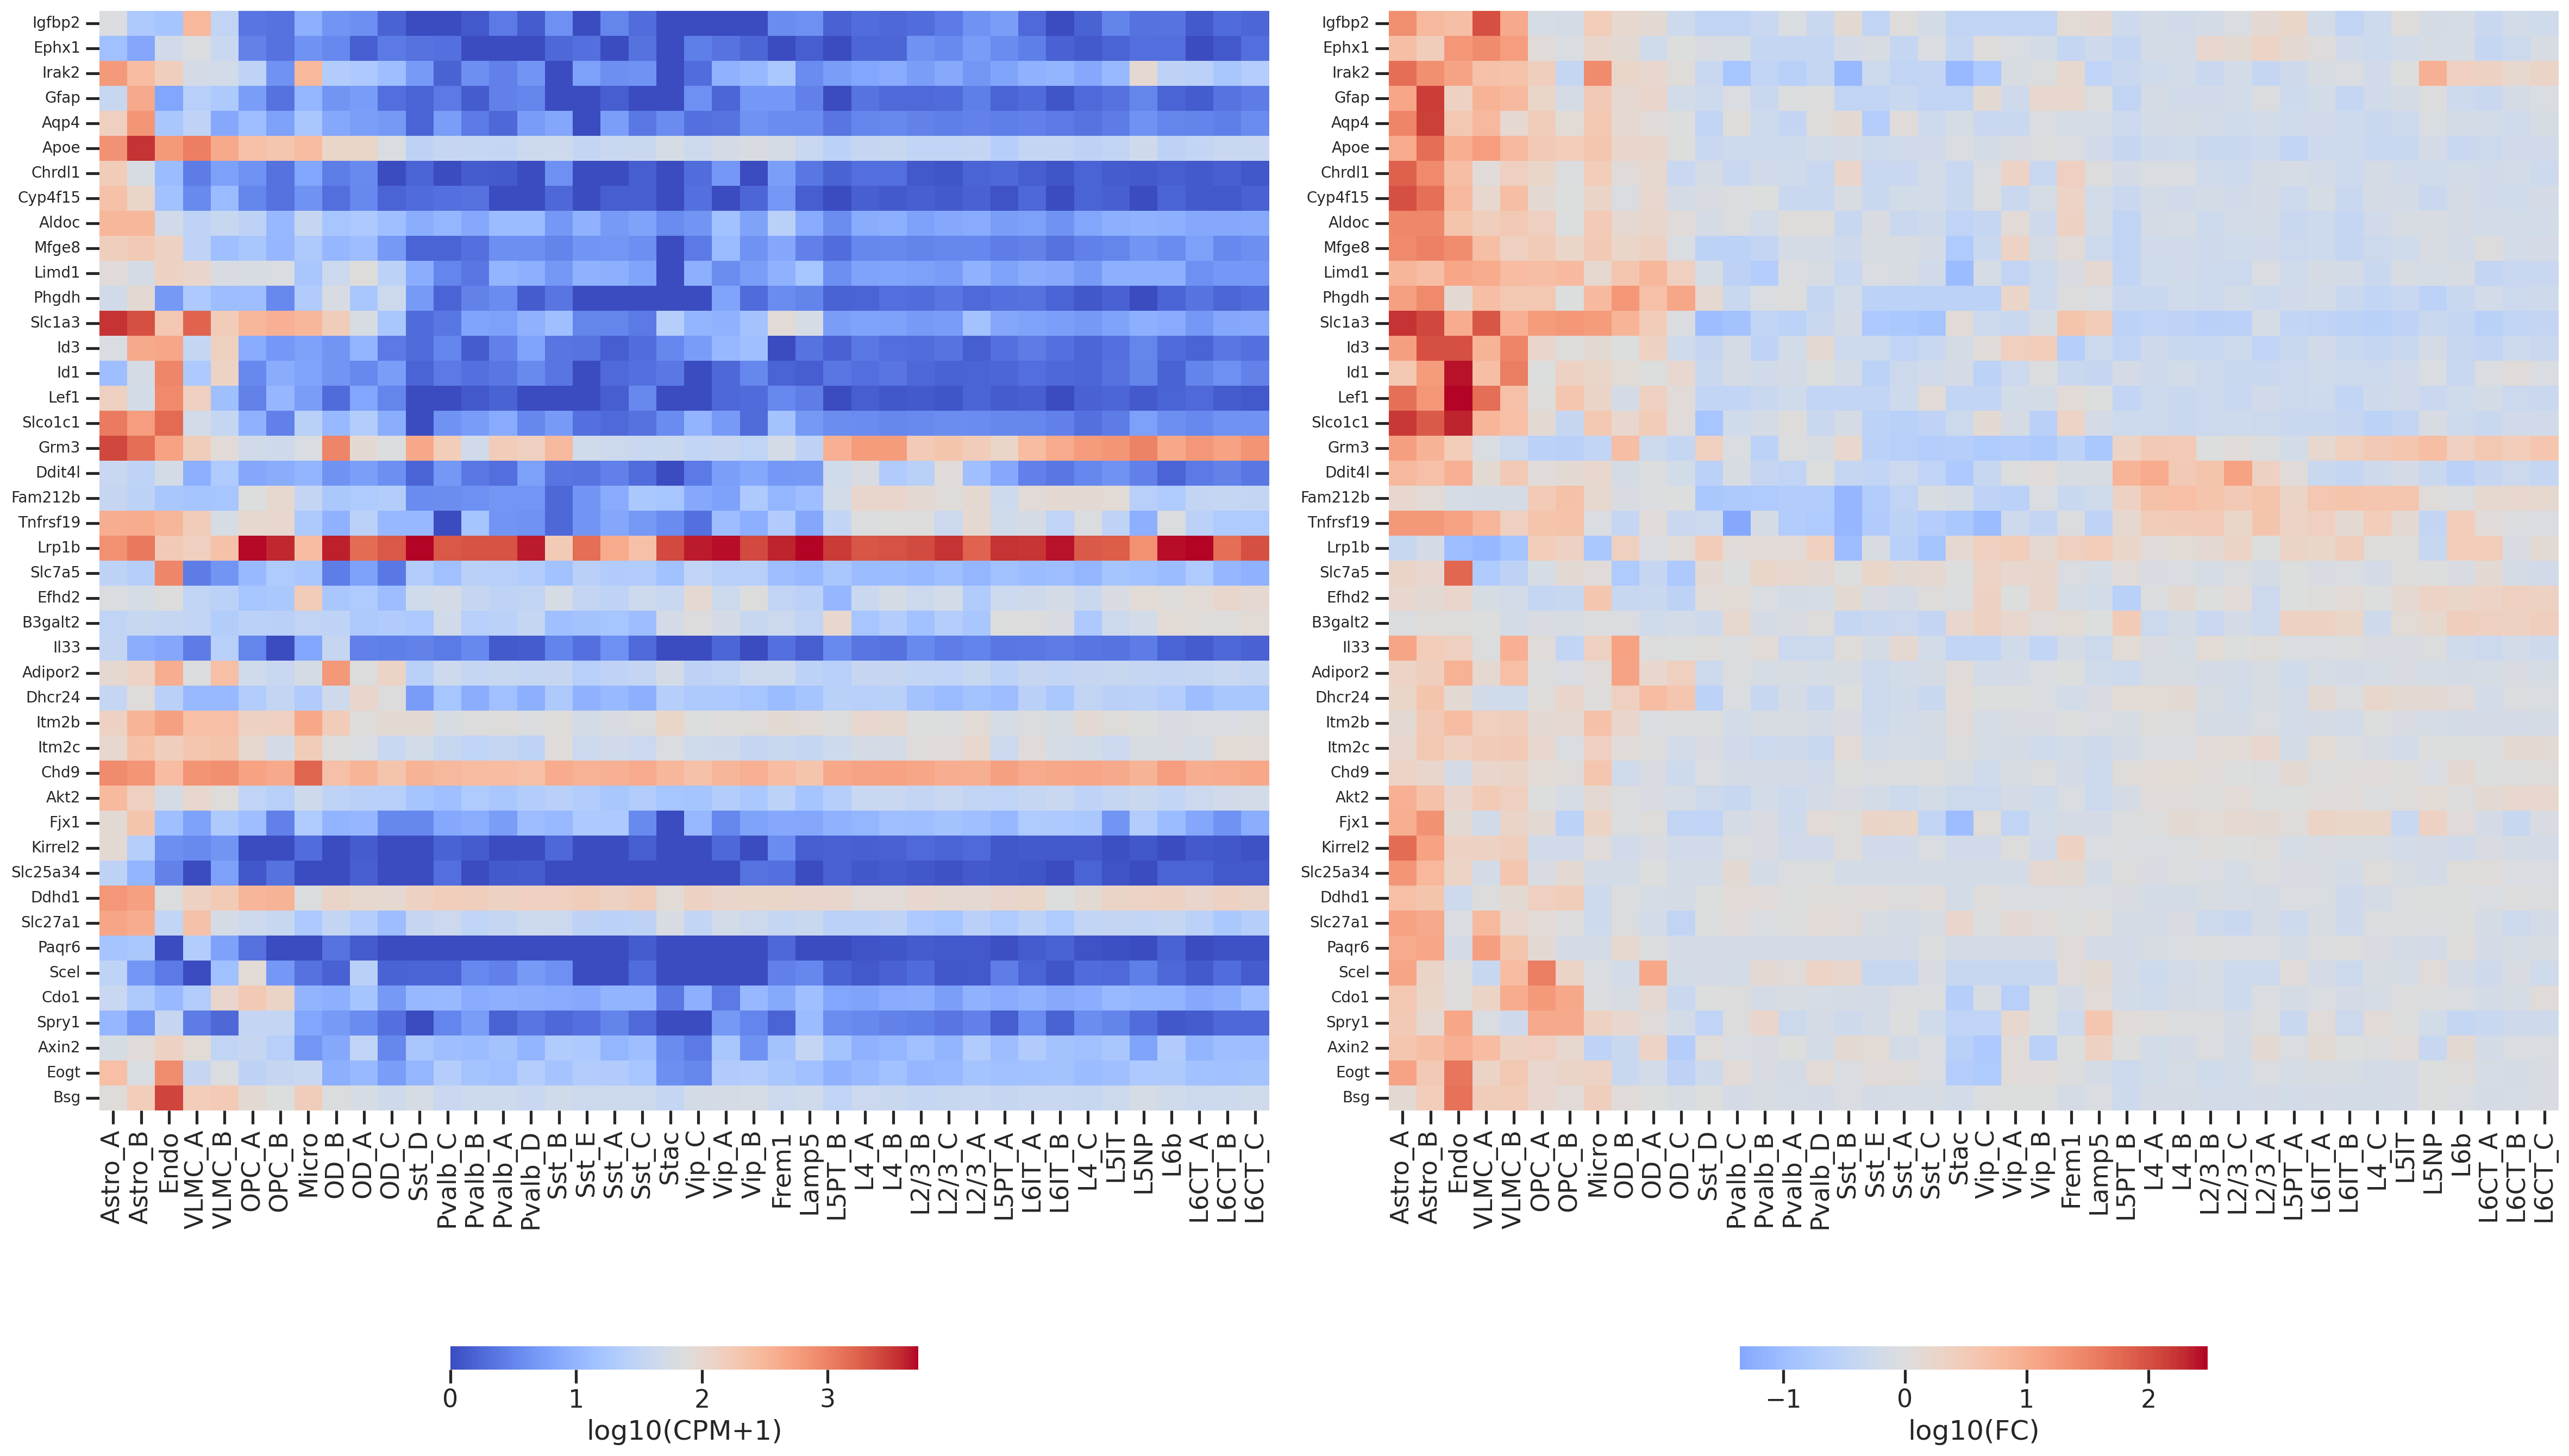

In [16]:
fig, axs = plt.subplots(1,2,figsize=(12*2,15))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check all

In [17]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        # & df['source'].str.contains('analysis')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

205 (205,) [] []


In [18]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

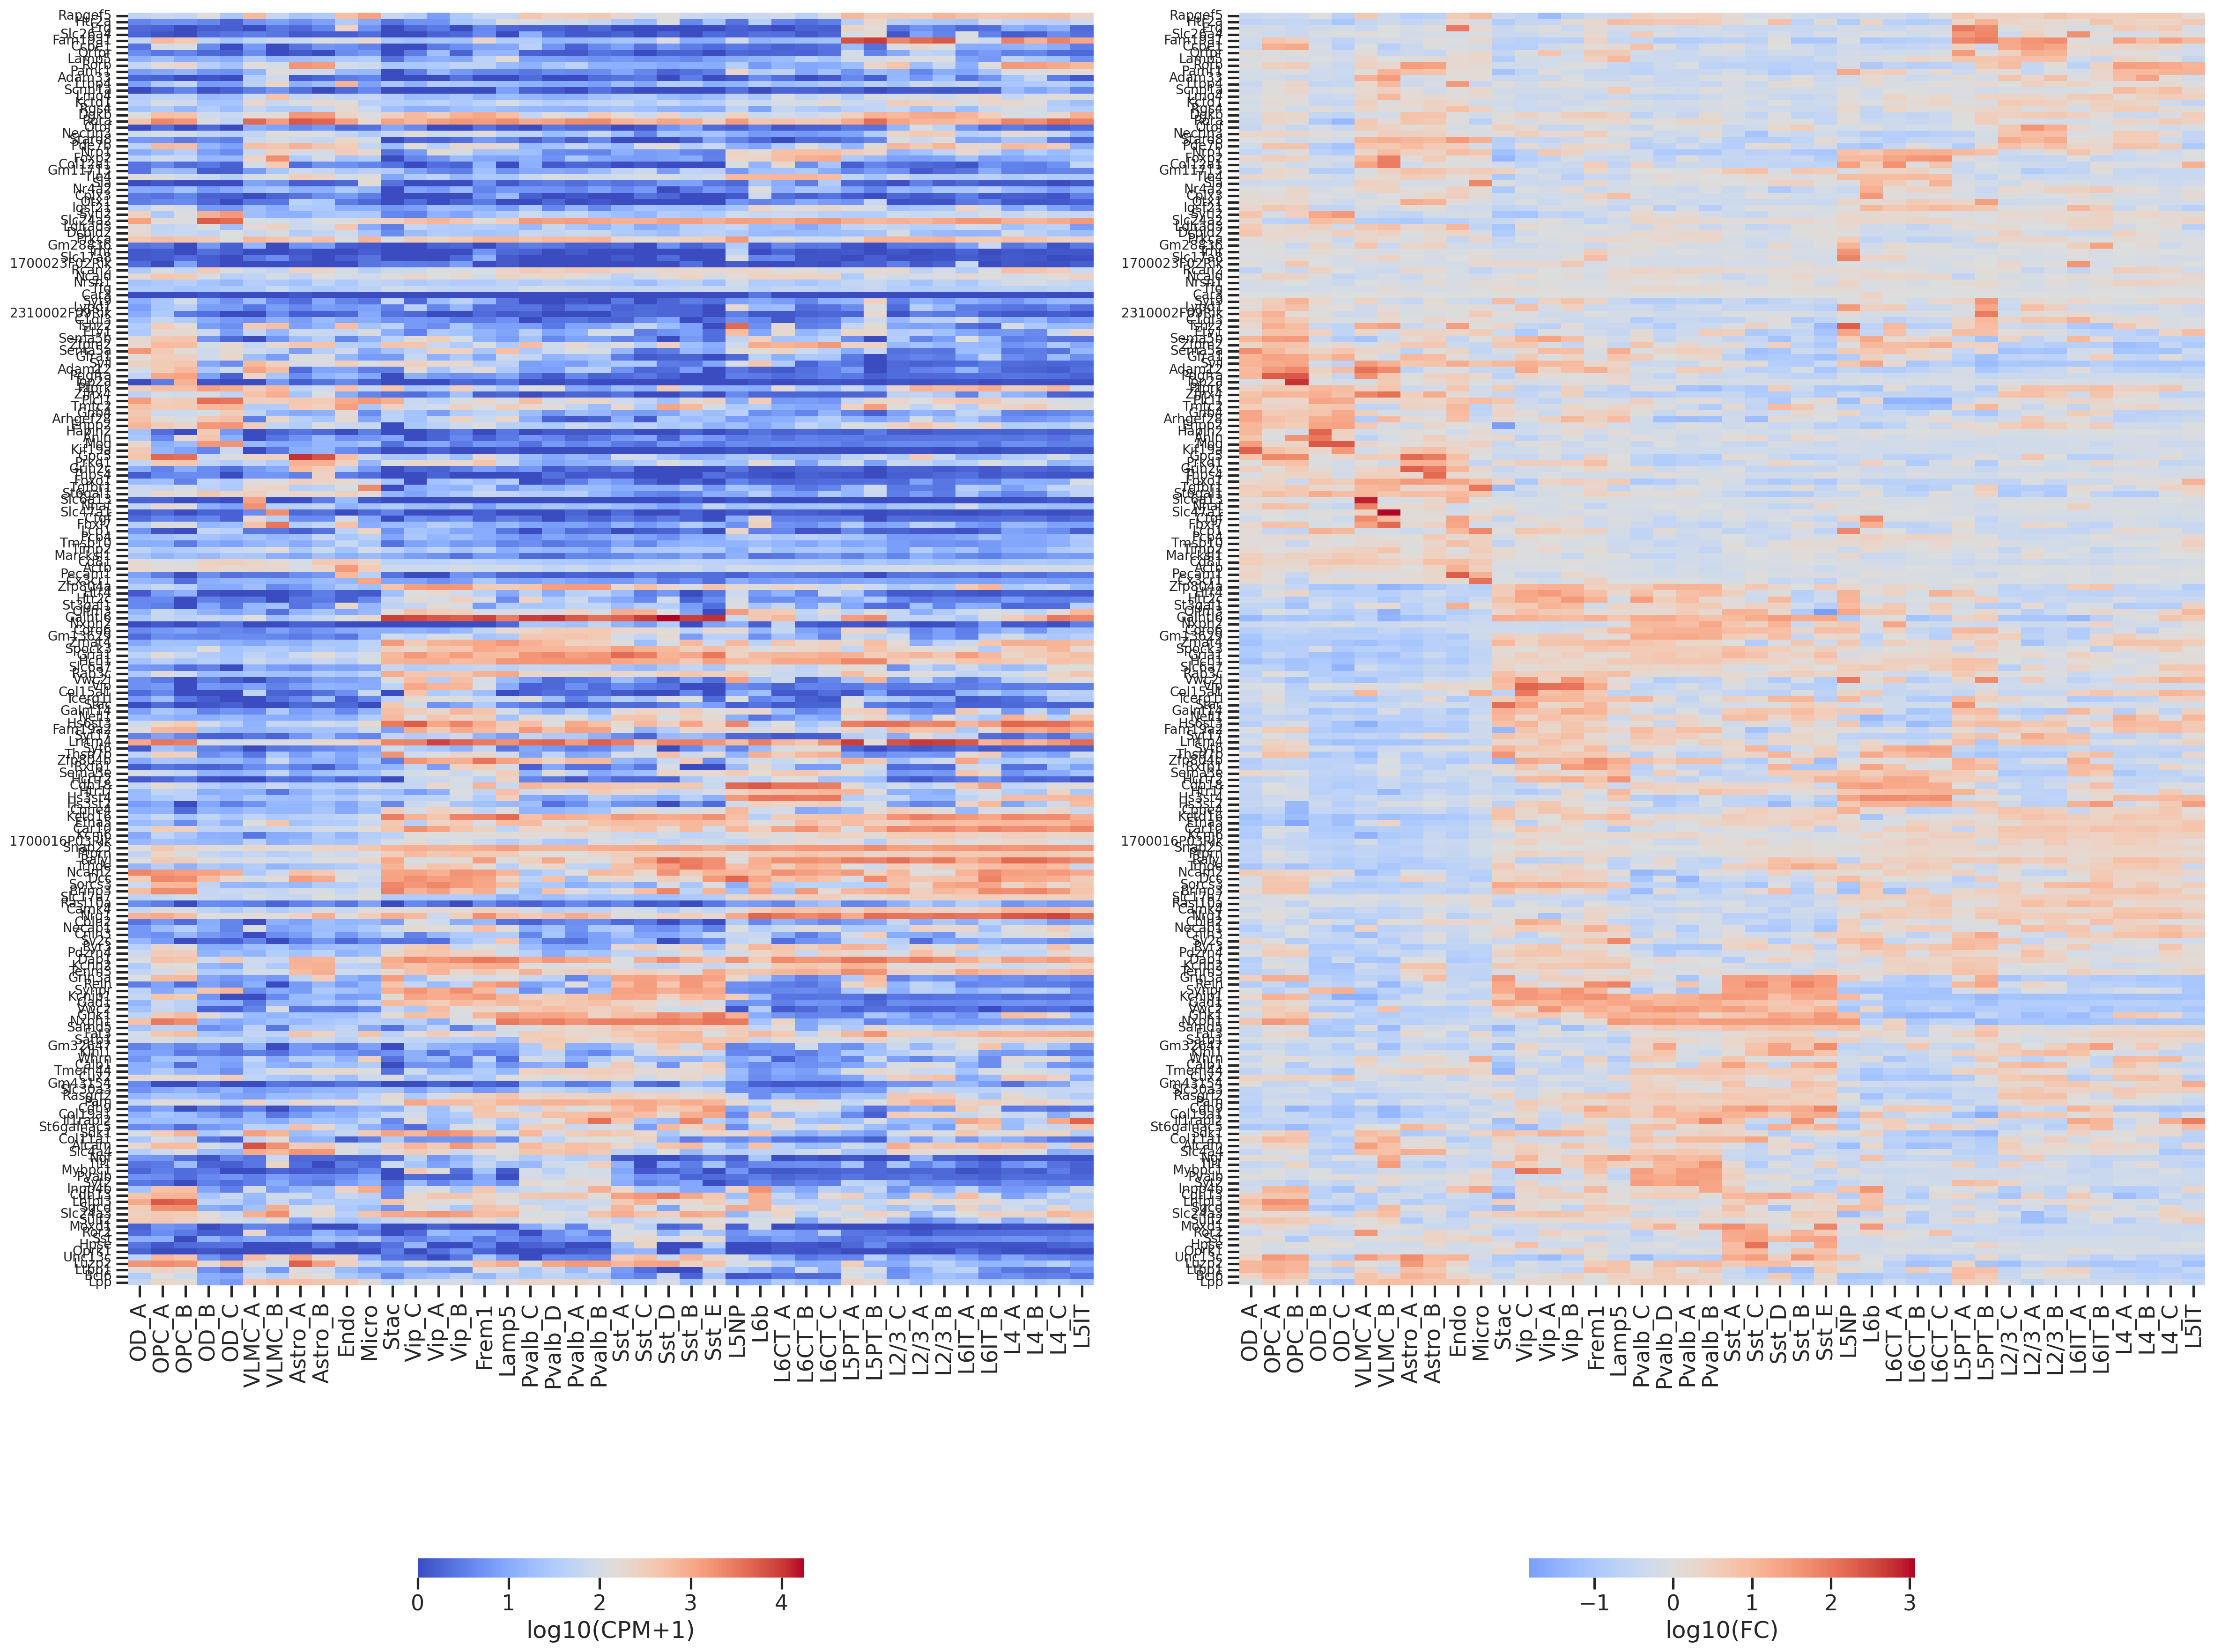

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check Cheng

In [20]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        & df['source'].str.contains('Cheng22')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

117 (117,) [] []


In [21]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

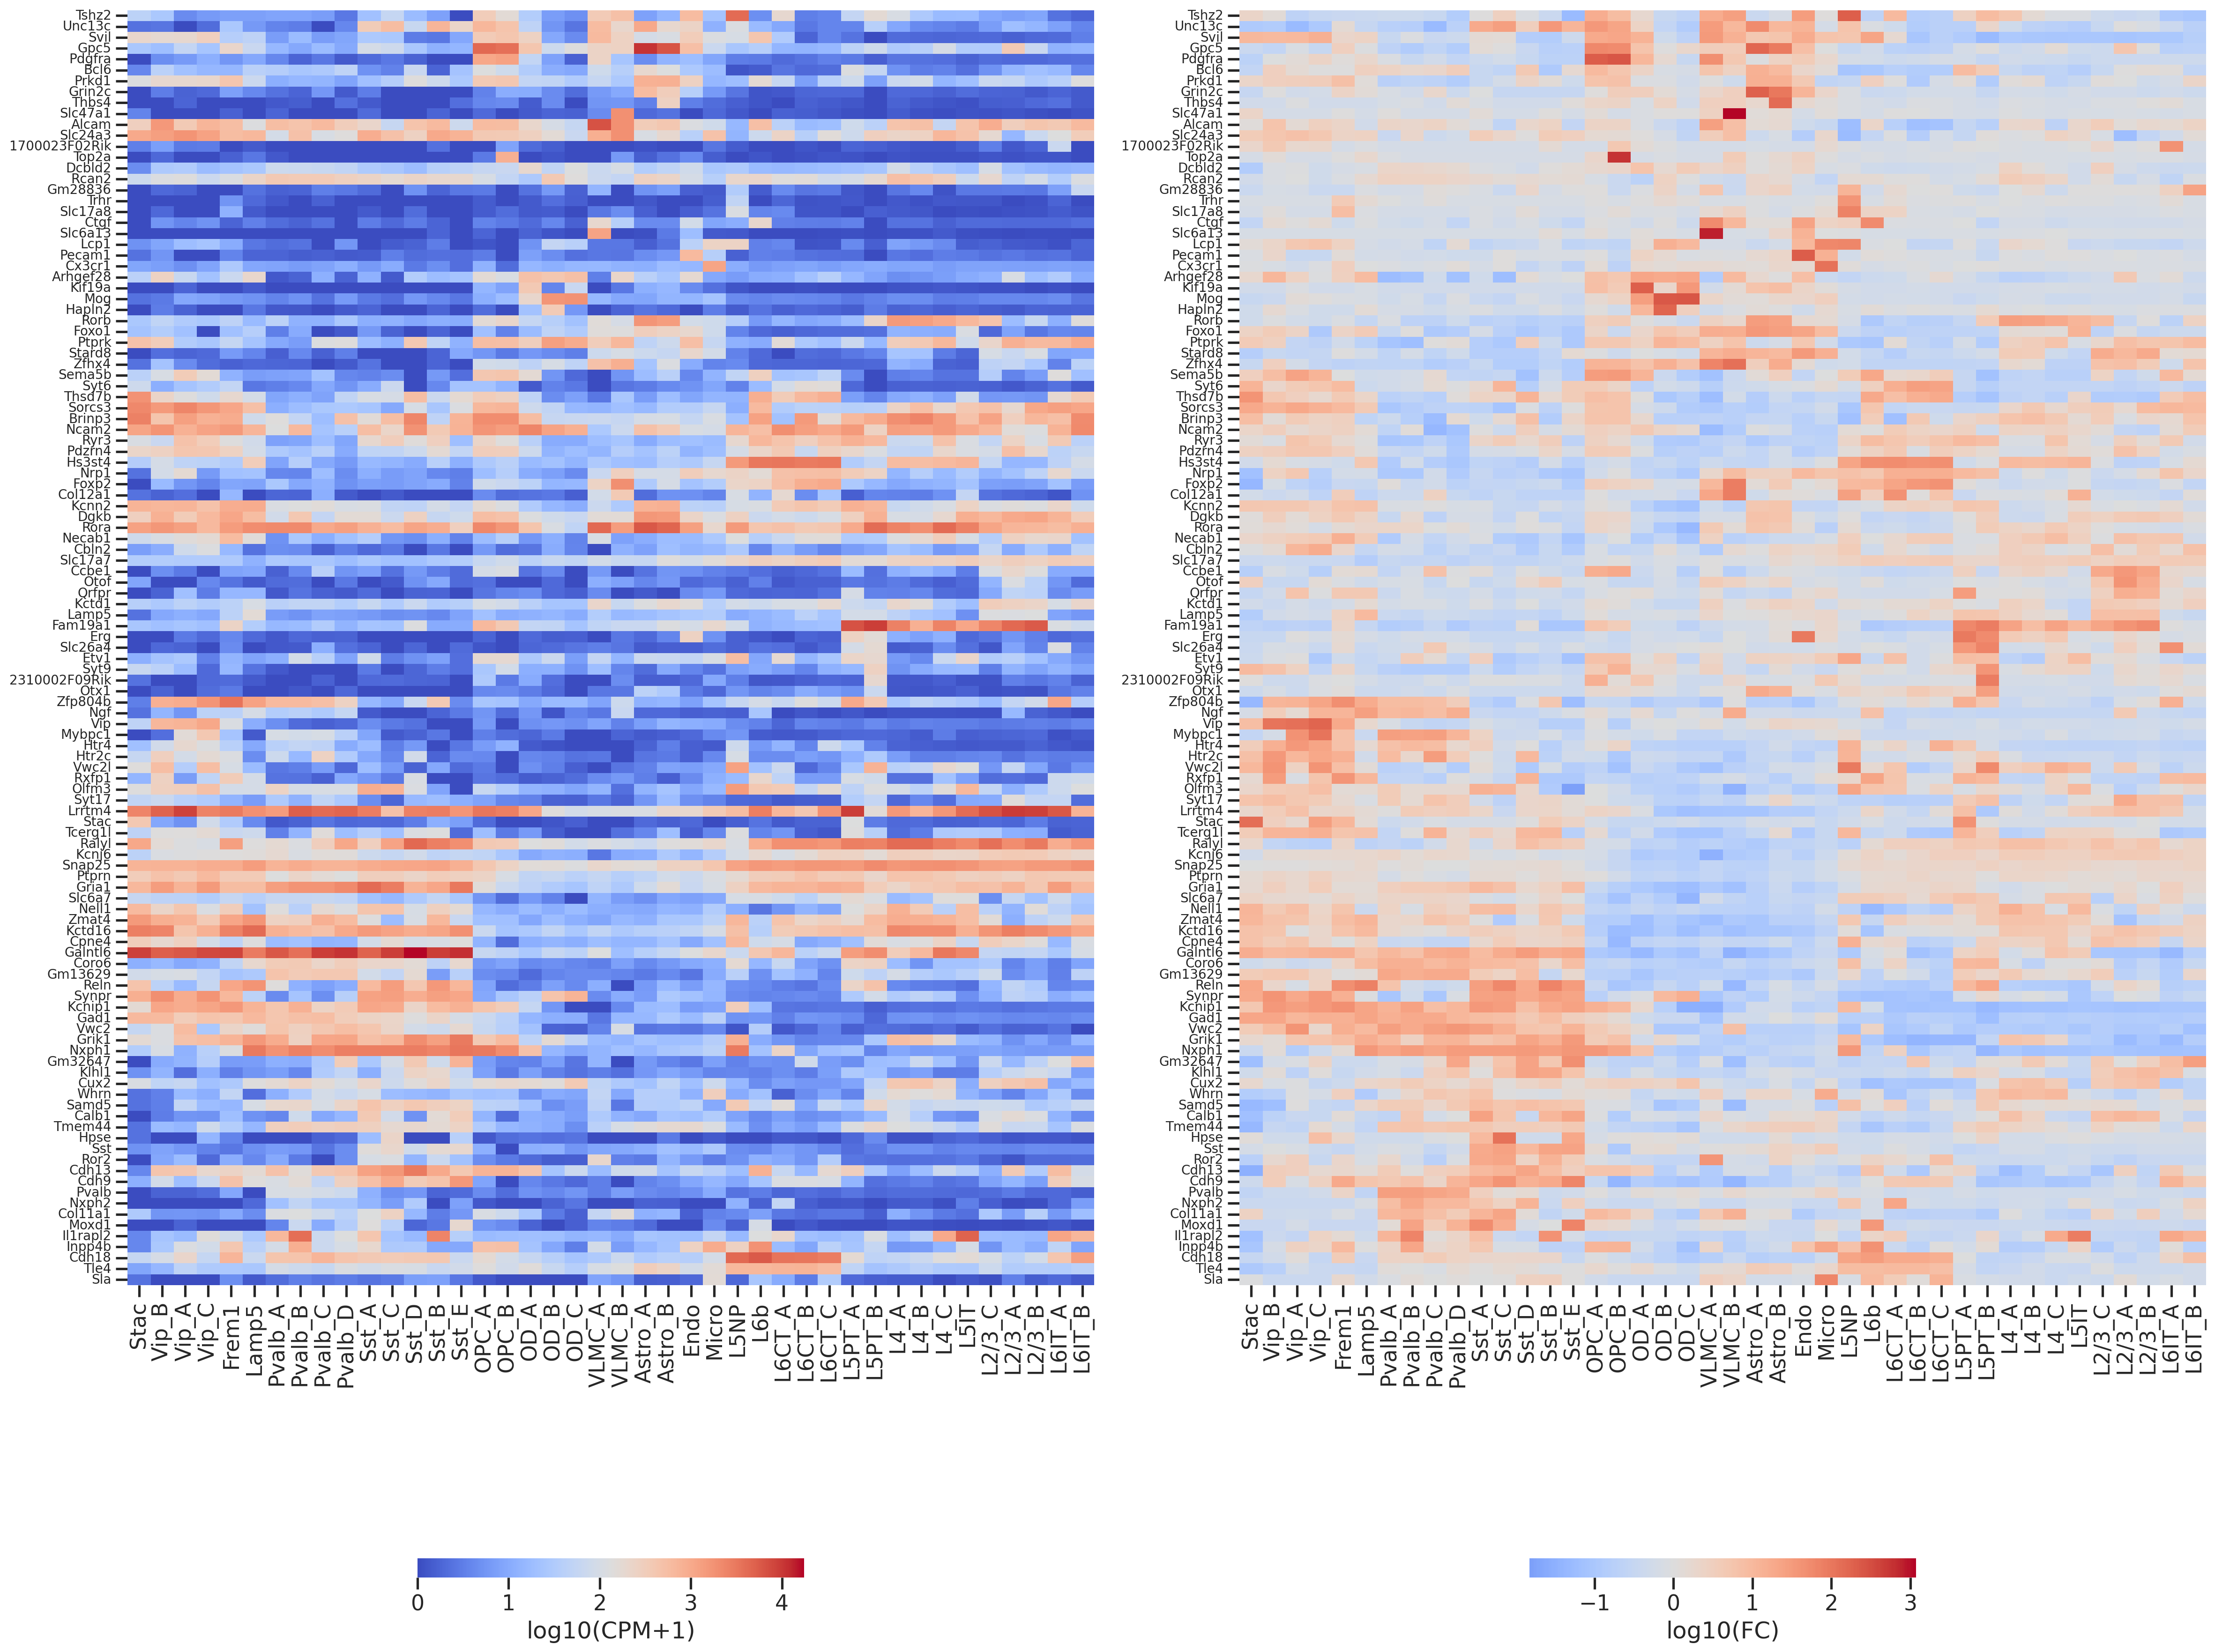

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    # vmax=3,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check Zador

In [23]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        & df['source'].str.contains('Zador')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

107 (107,) [] []


In [24]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

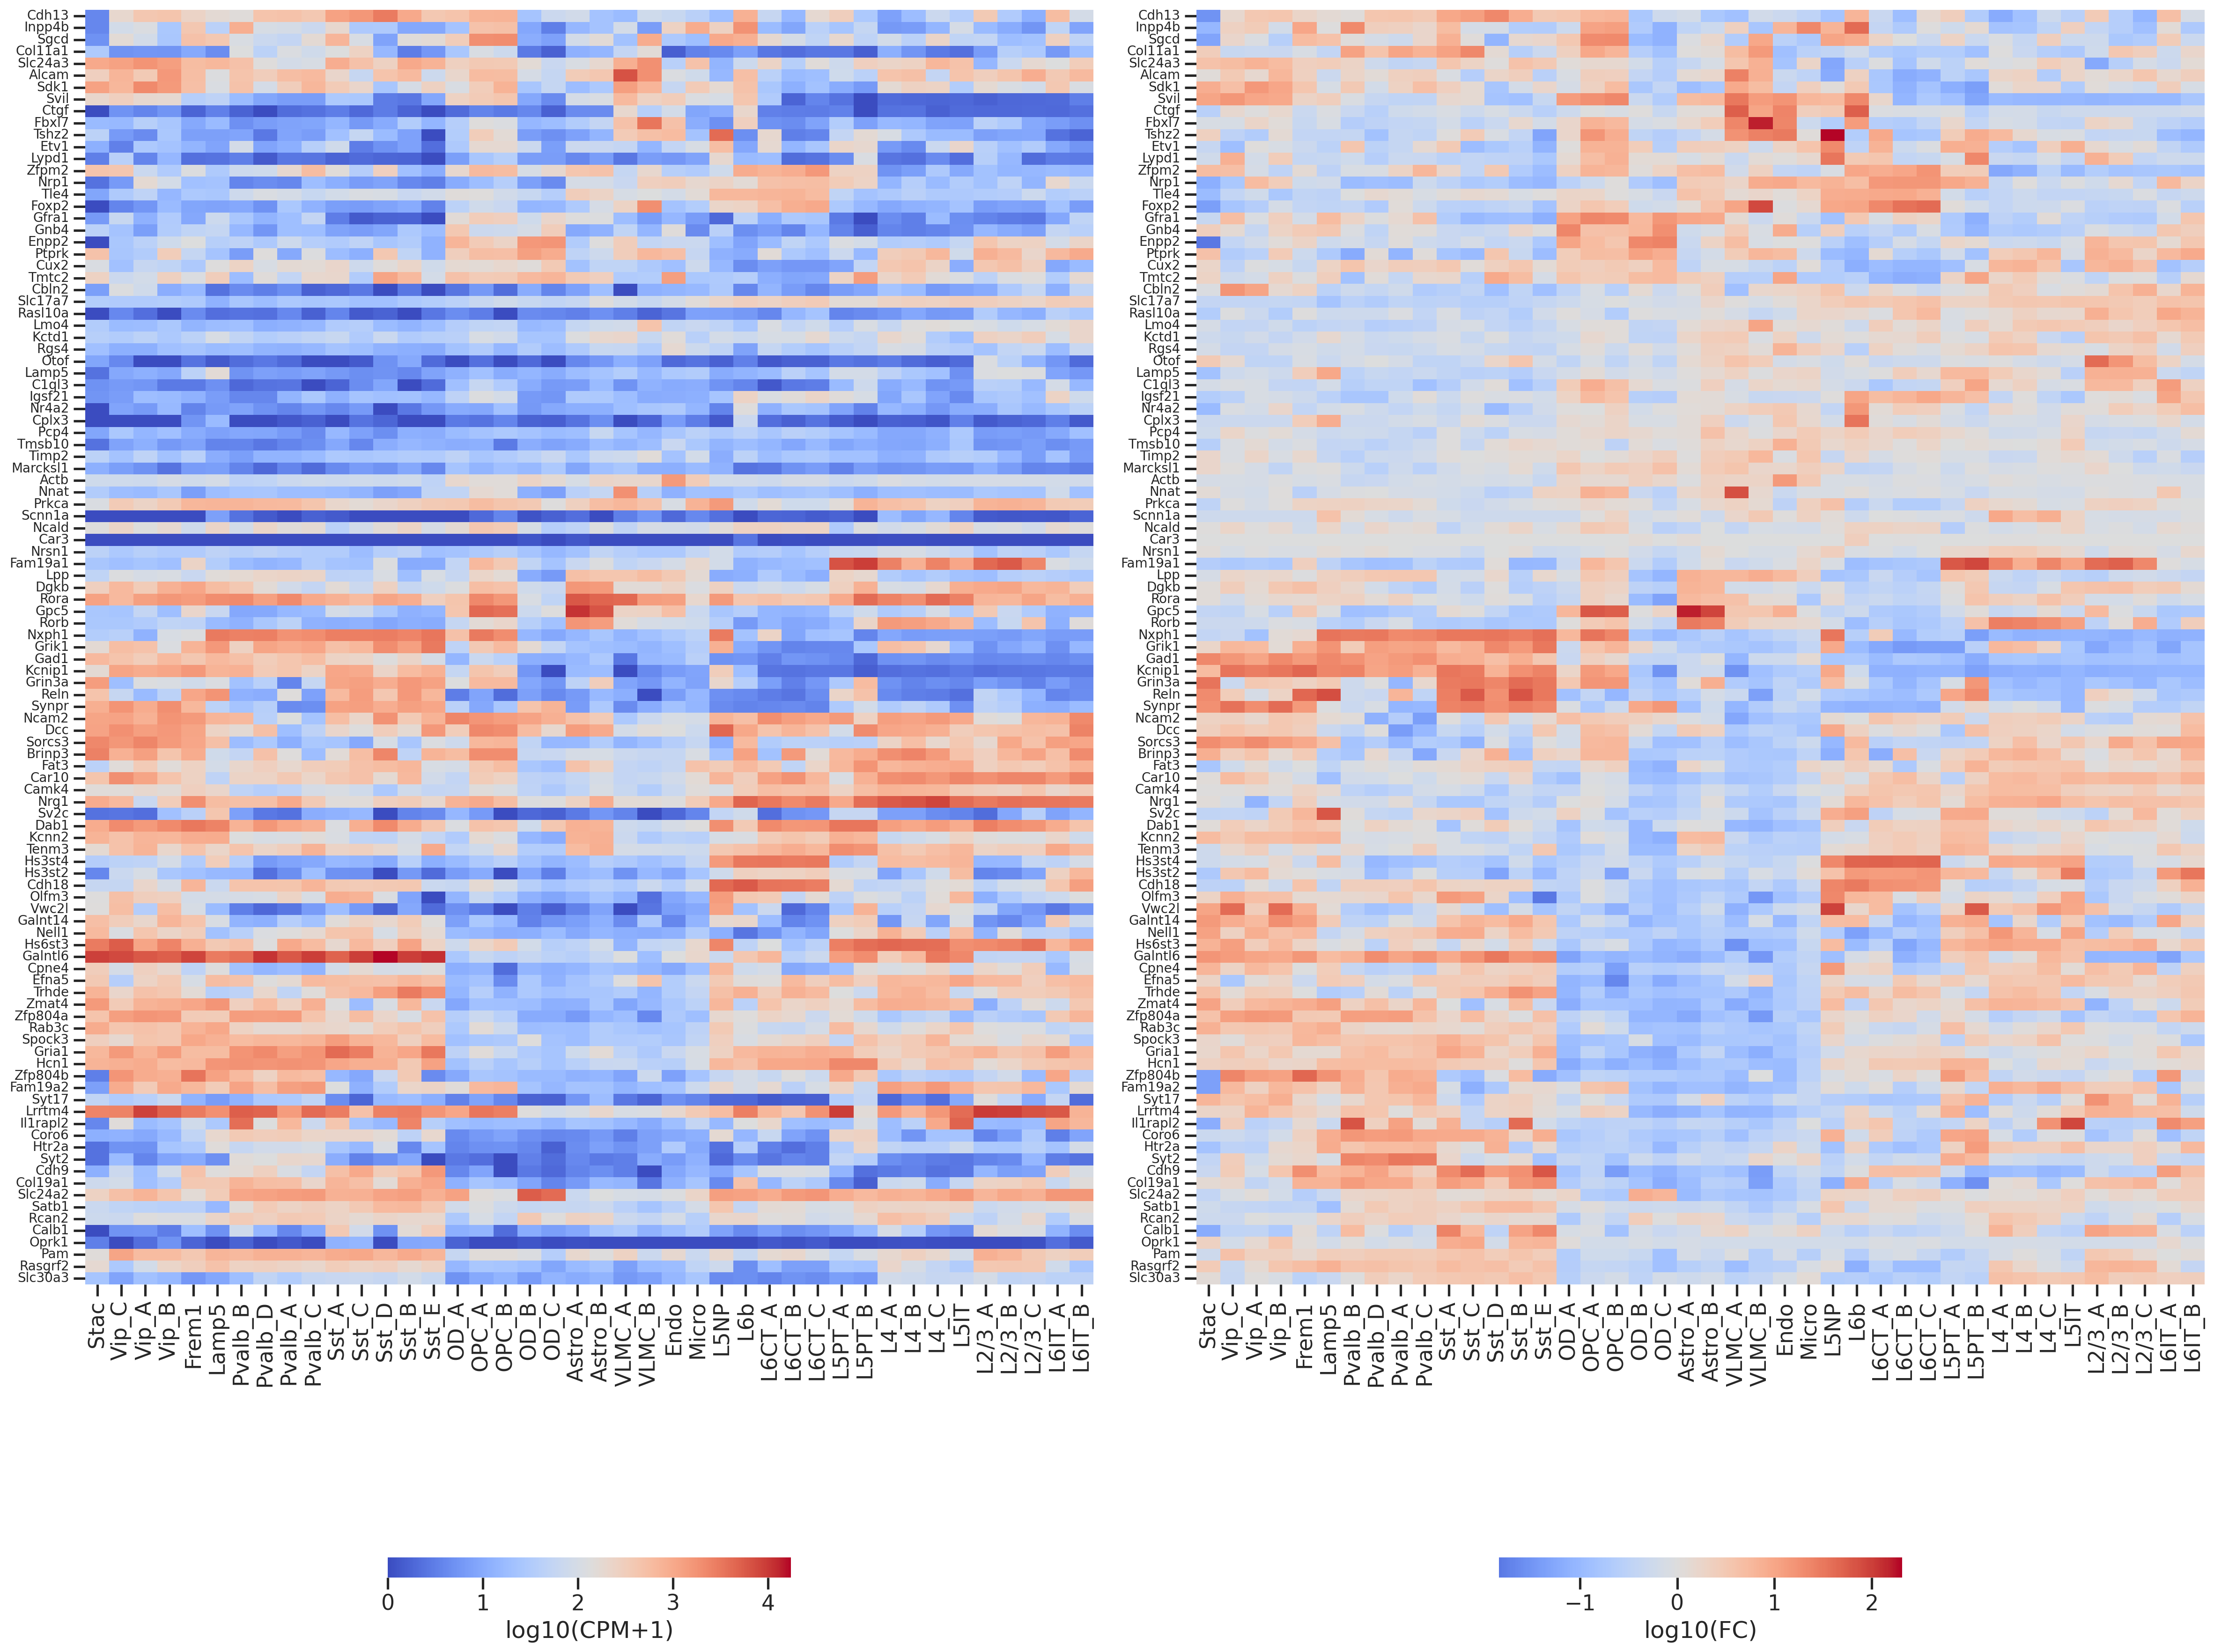

In [25]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    # vmax=3,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check PROPOSE

In [26]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        & df['source'].str.contains('our analysis')
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

70 (70,) [] []


In [27]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

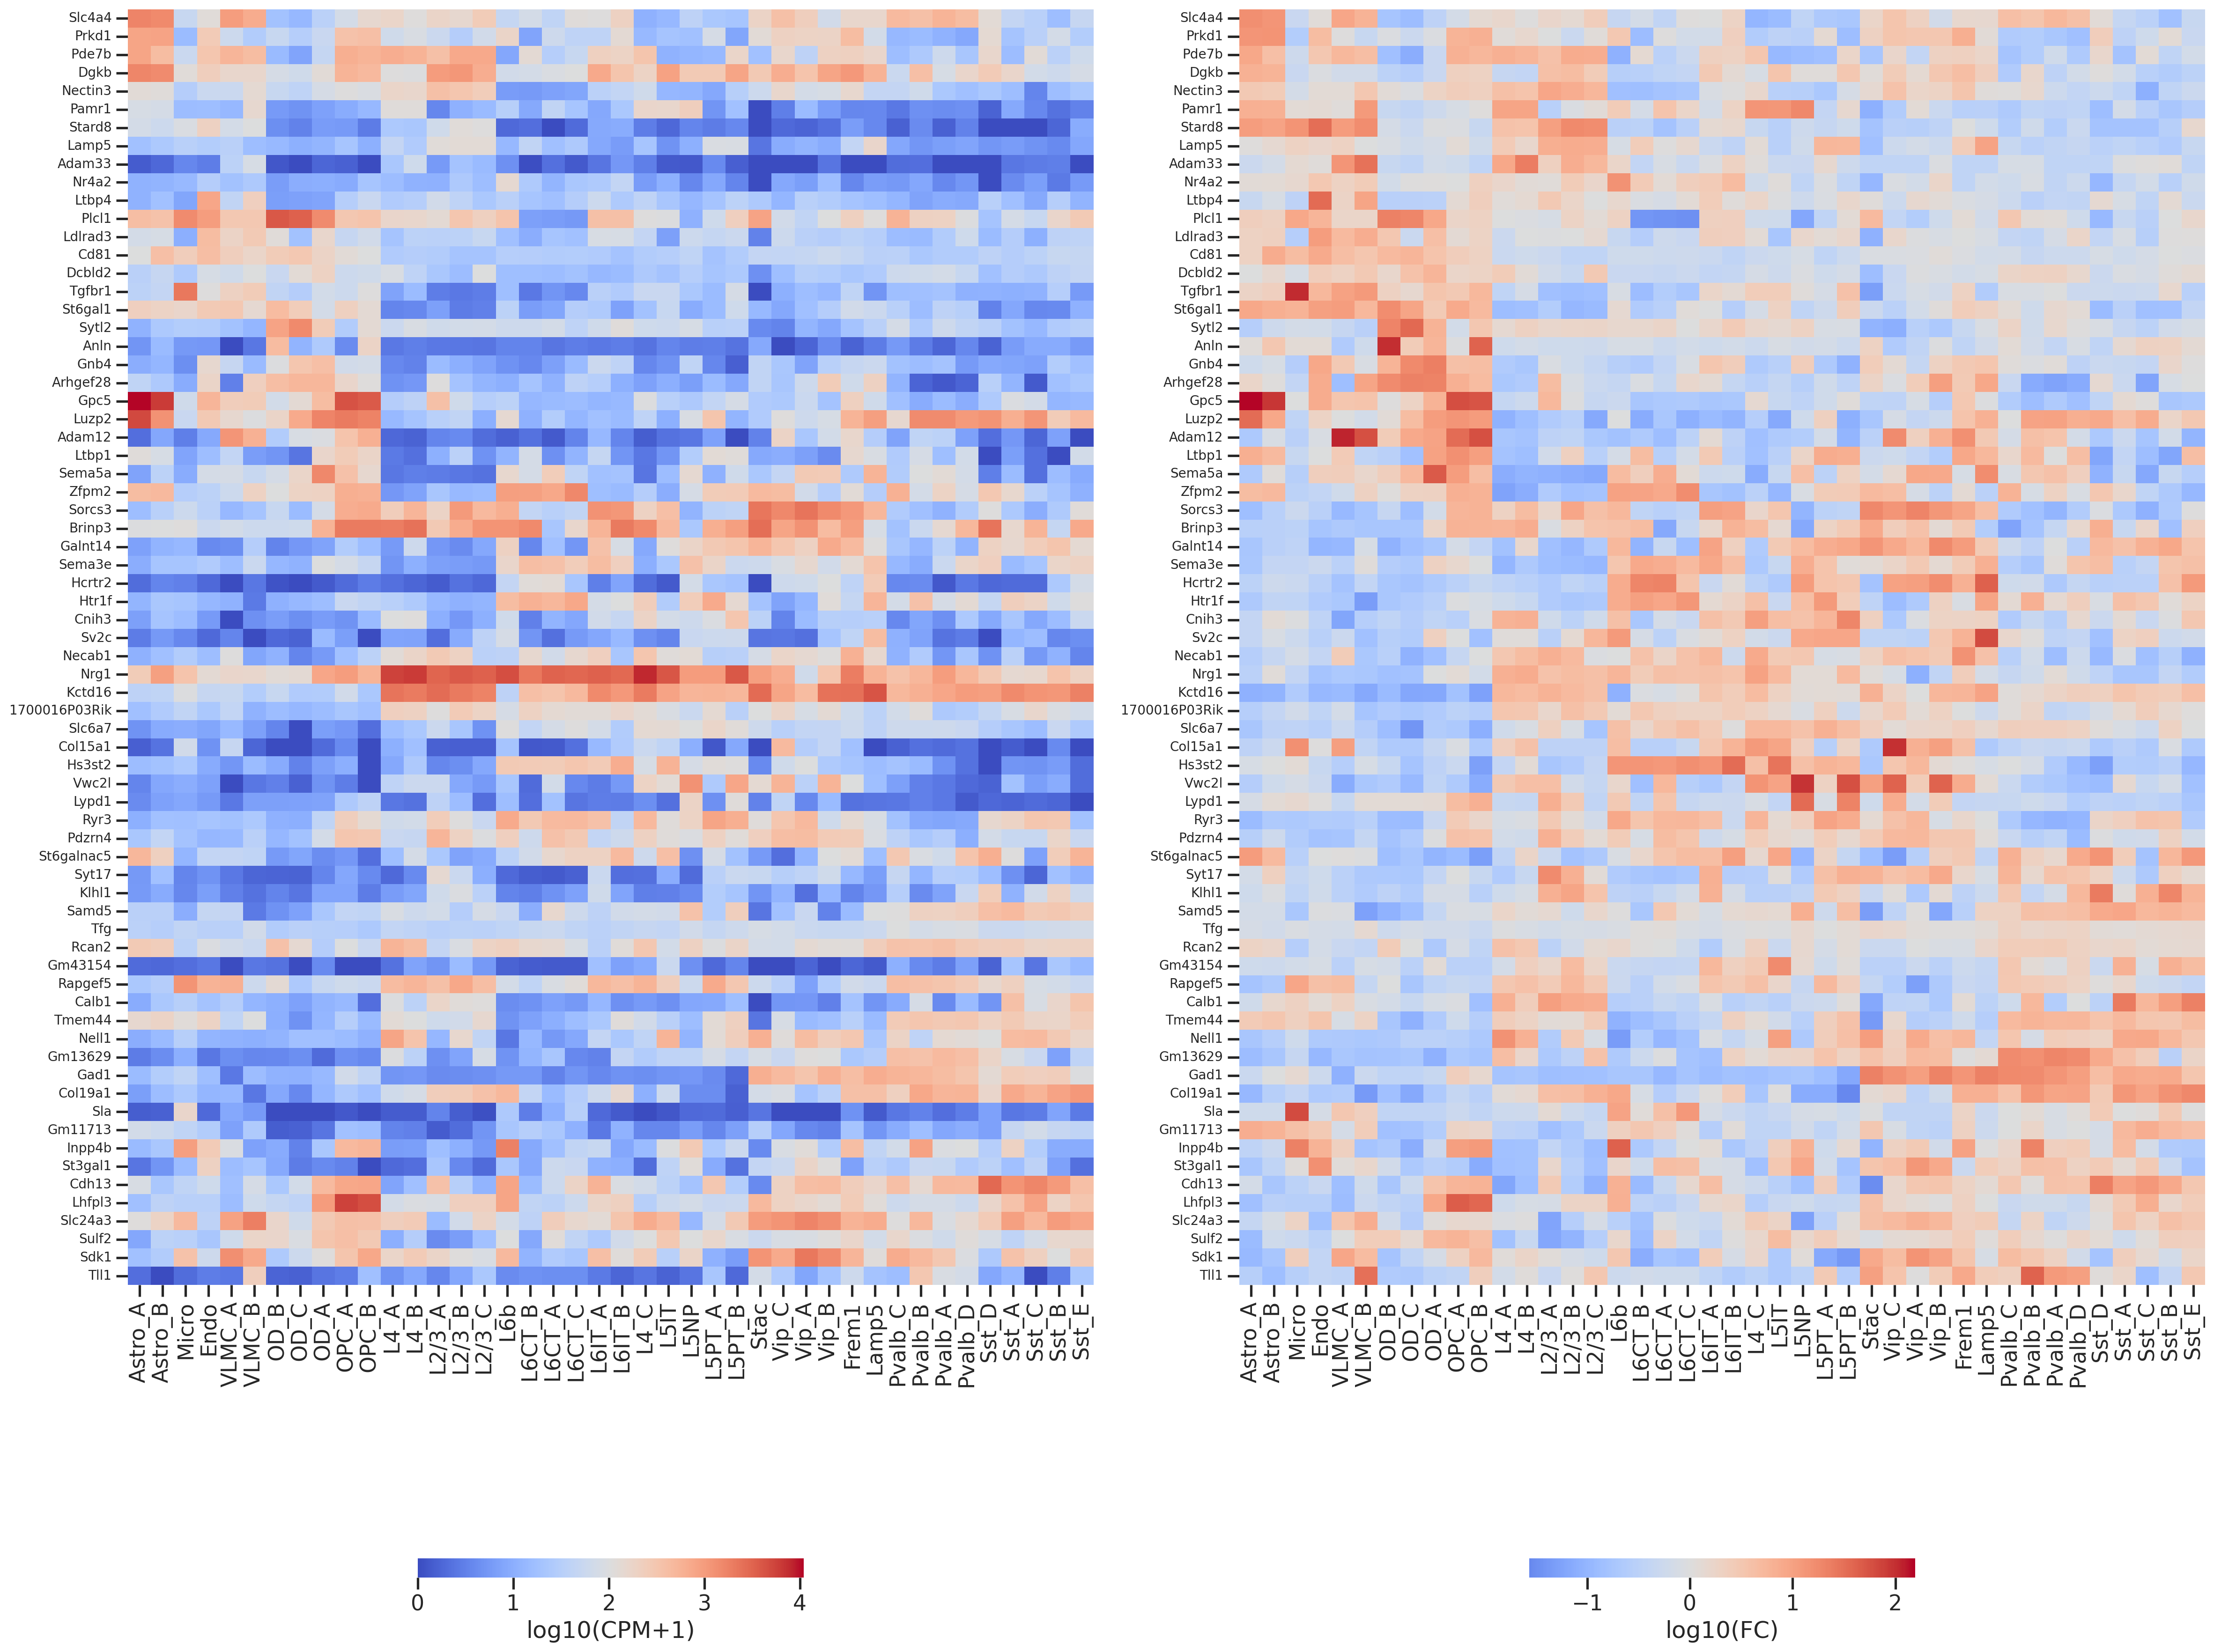

In [28]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    # vmax=3,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check Cheng and Zador

In [29]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        & (df['source'].str.contains('Cheng22') | df['source'].str.contains('Zador'))
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

173 (173,) [] []


In [30]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

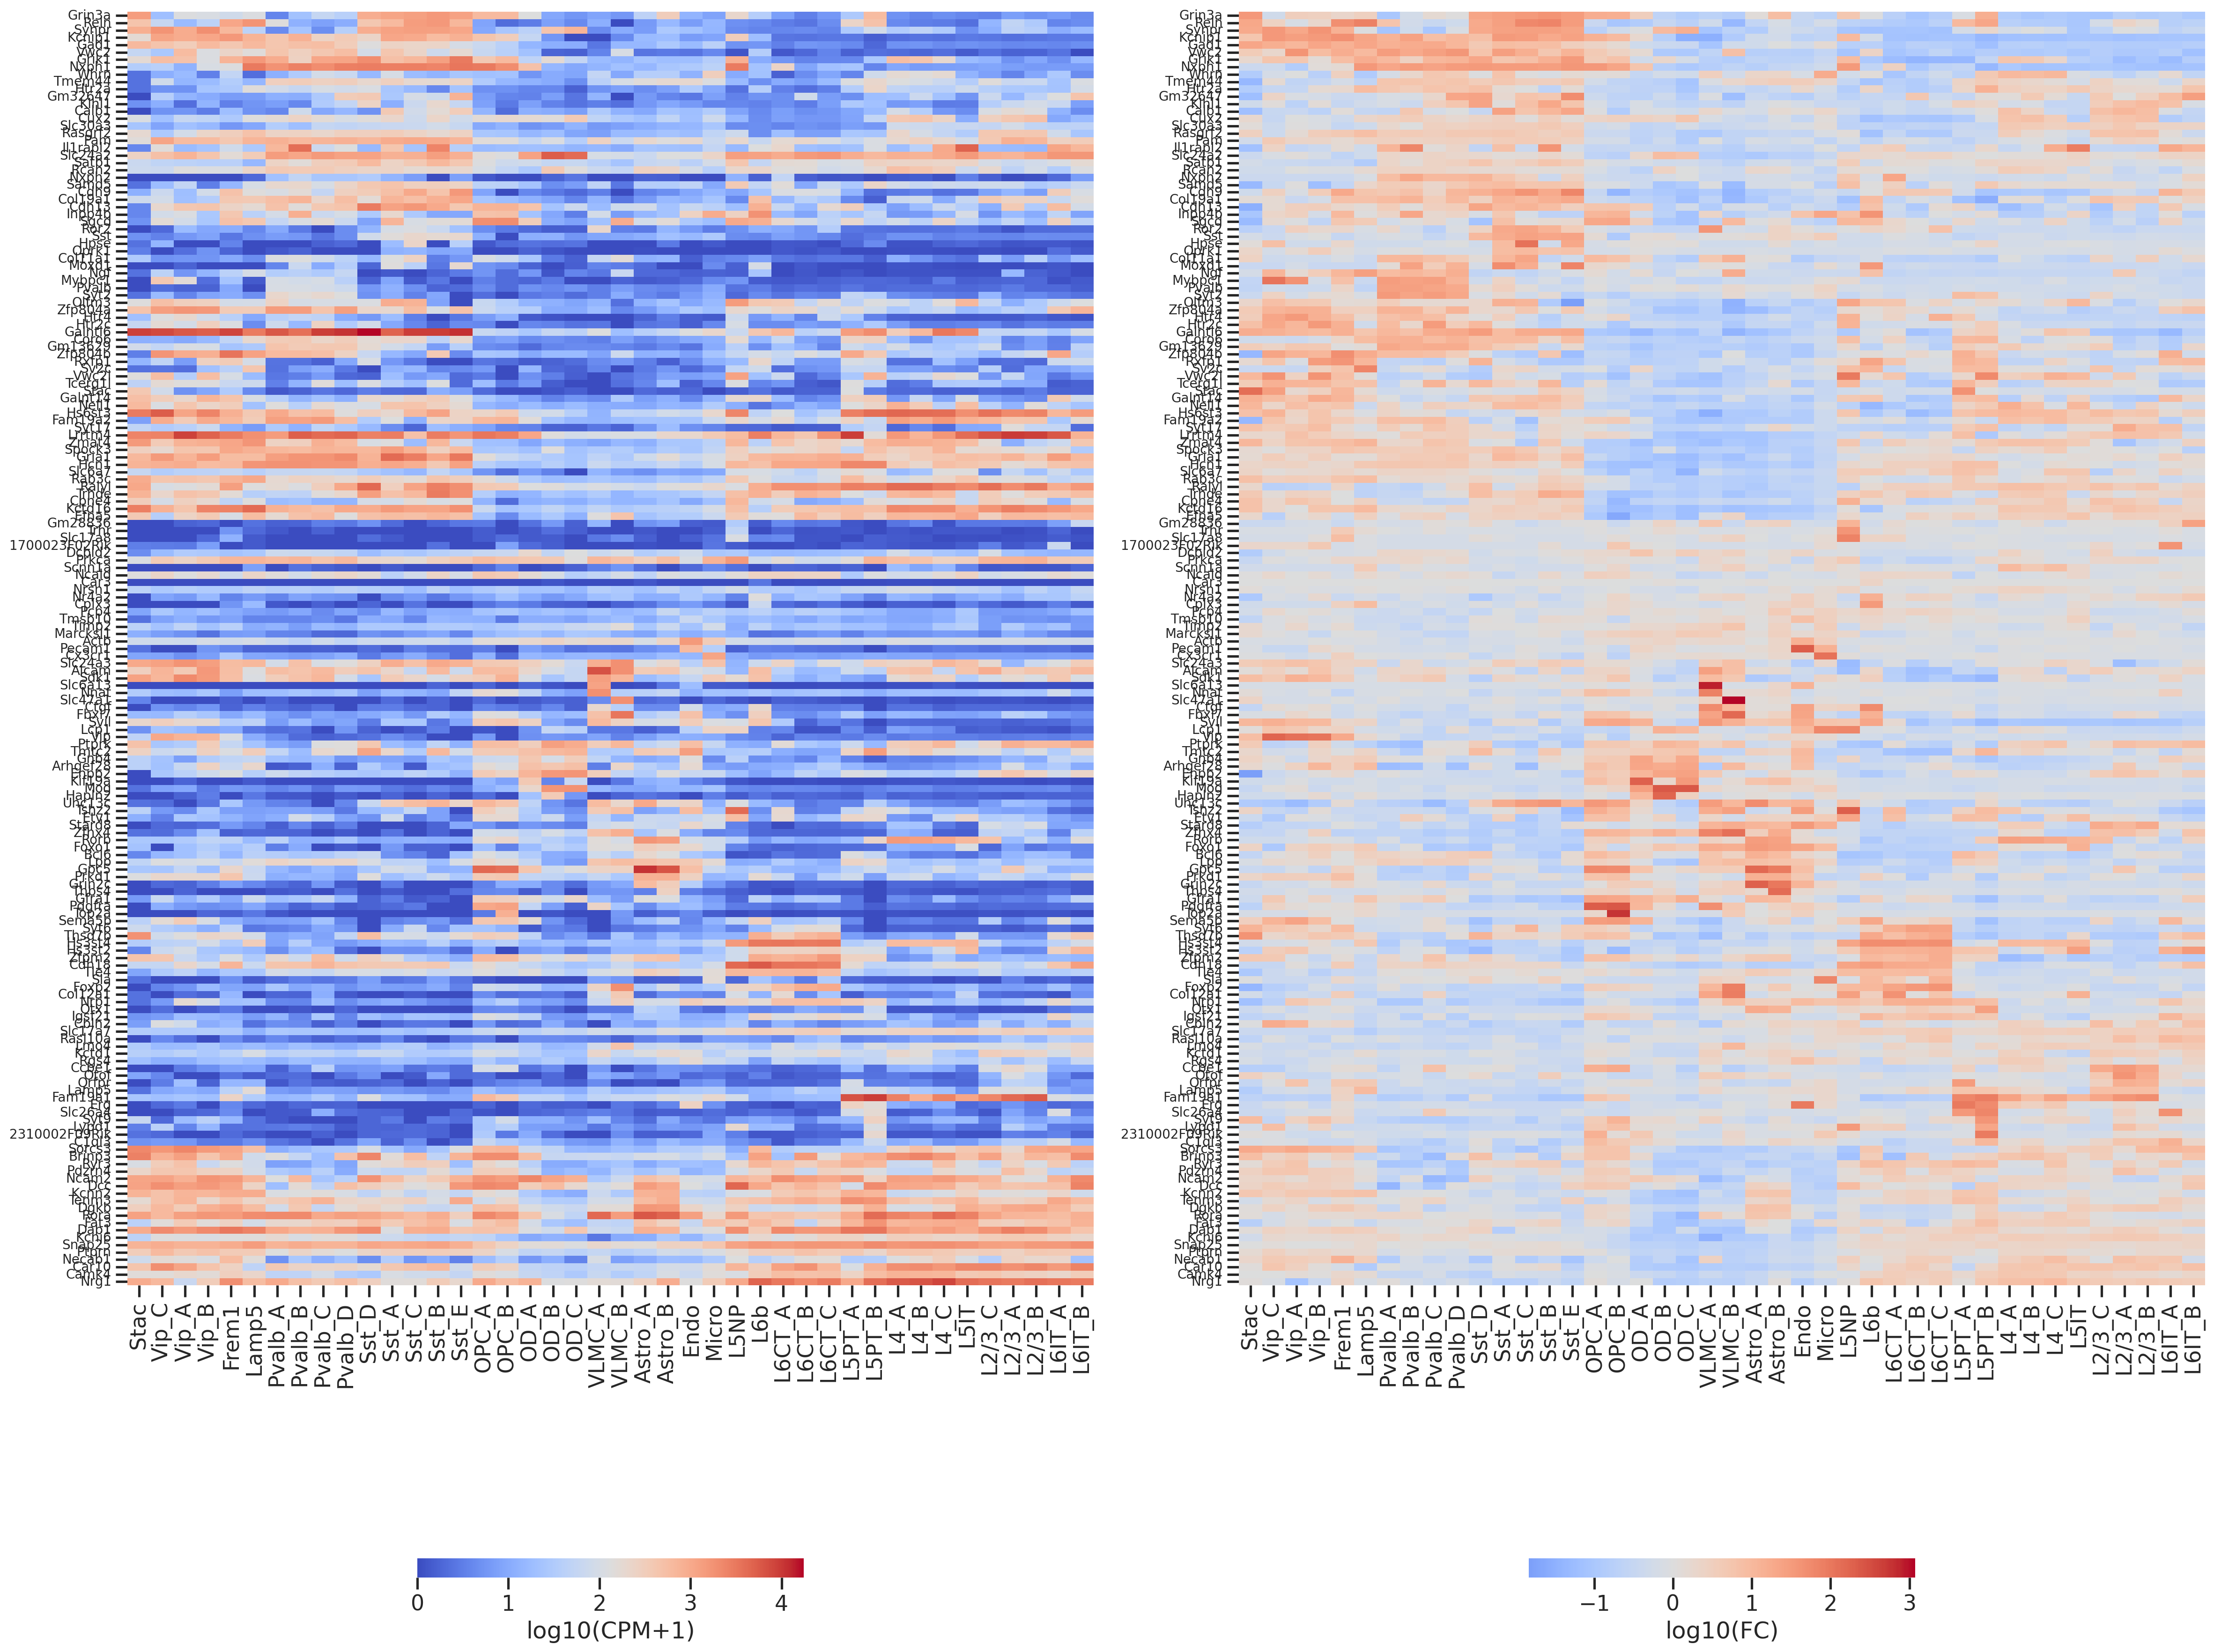

In [31]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    # vmax=3,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()

# check non Cheng and Zador

In [36]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('All cell types')
        & (df['source']=='our analysis') #.str.contains('Cheng22') | df['source'].str.contains('Zador'))
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

32 (32,) [] []


In [40]:
f = "../results/MERFISH_gene_panel_Current_Mar7_v5.csv"
df = pd.read_csv(f)
df = df[(df['why included']=='All cell types')
        & (df['source']=='our analysis') #.str.contains('Cheng22') | df['source'].str.contains('Zador'))
       ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

29 (29,) [] []


In [35]:
#
173+32

205

In [37]:
exp = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
lfc = exp - np.mean(exp, axis=1).reshape(-1,1)
rowidx = basicu.order_by_hc(lfc)
colidx = basicu.order_by_hc(lfc.T)

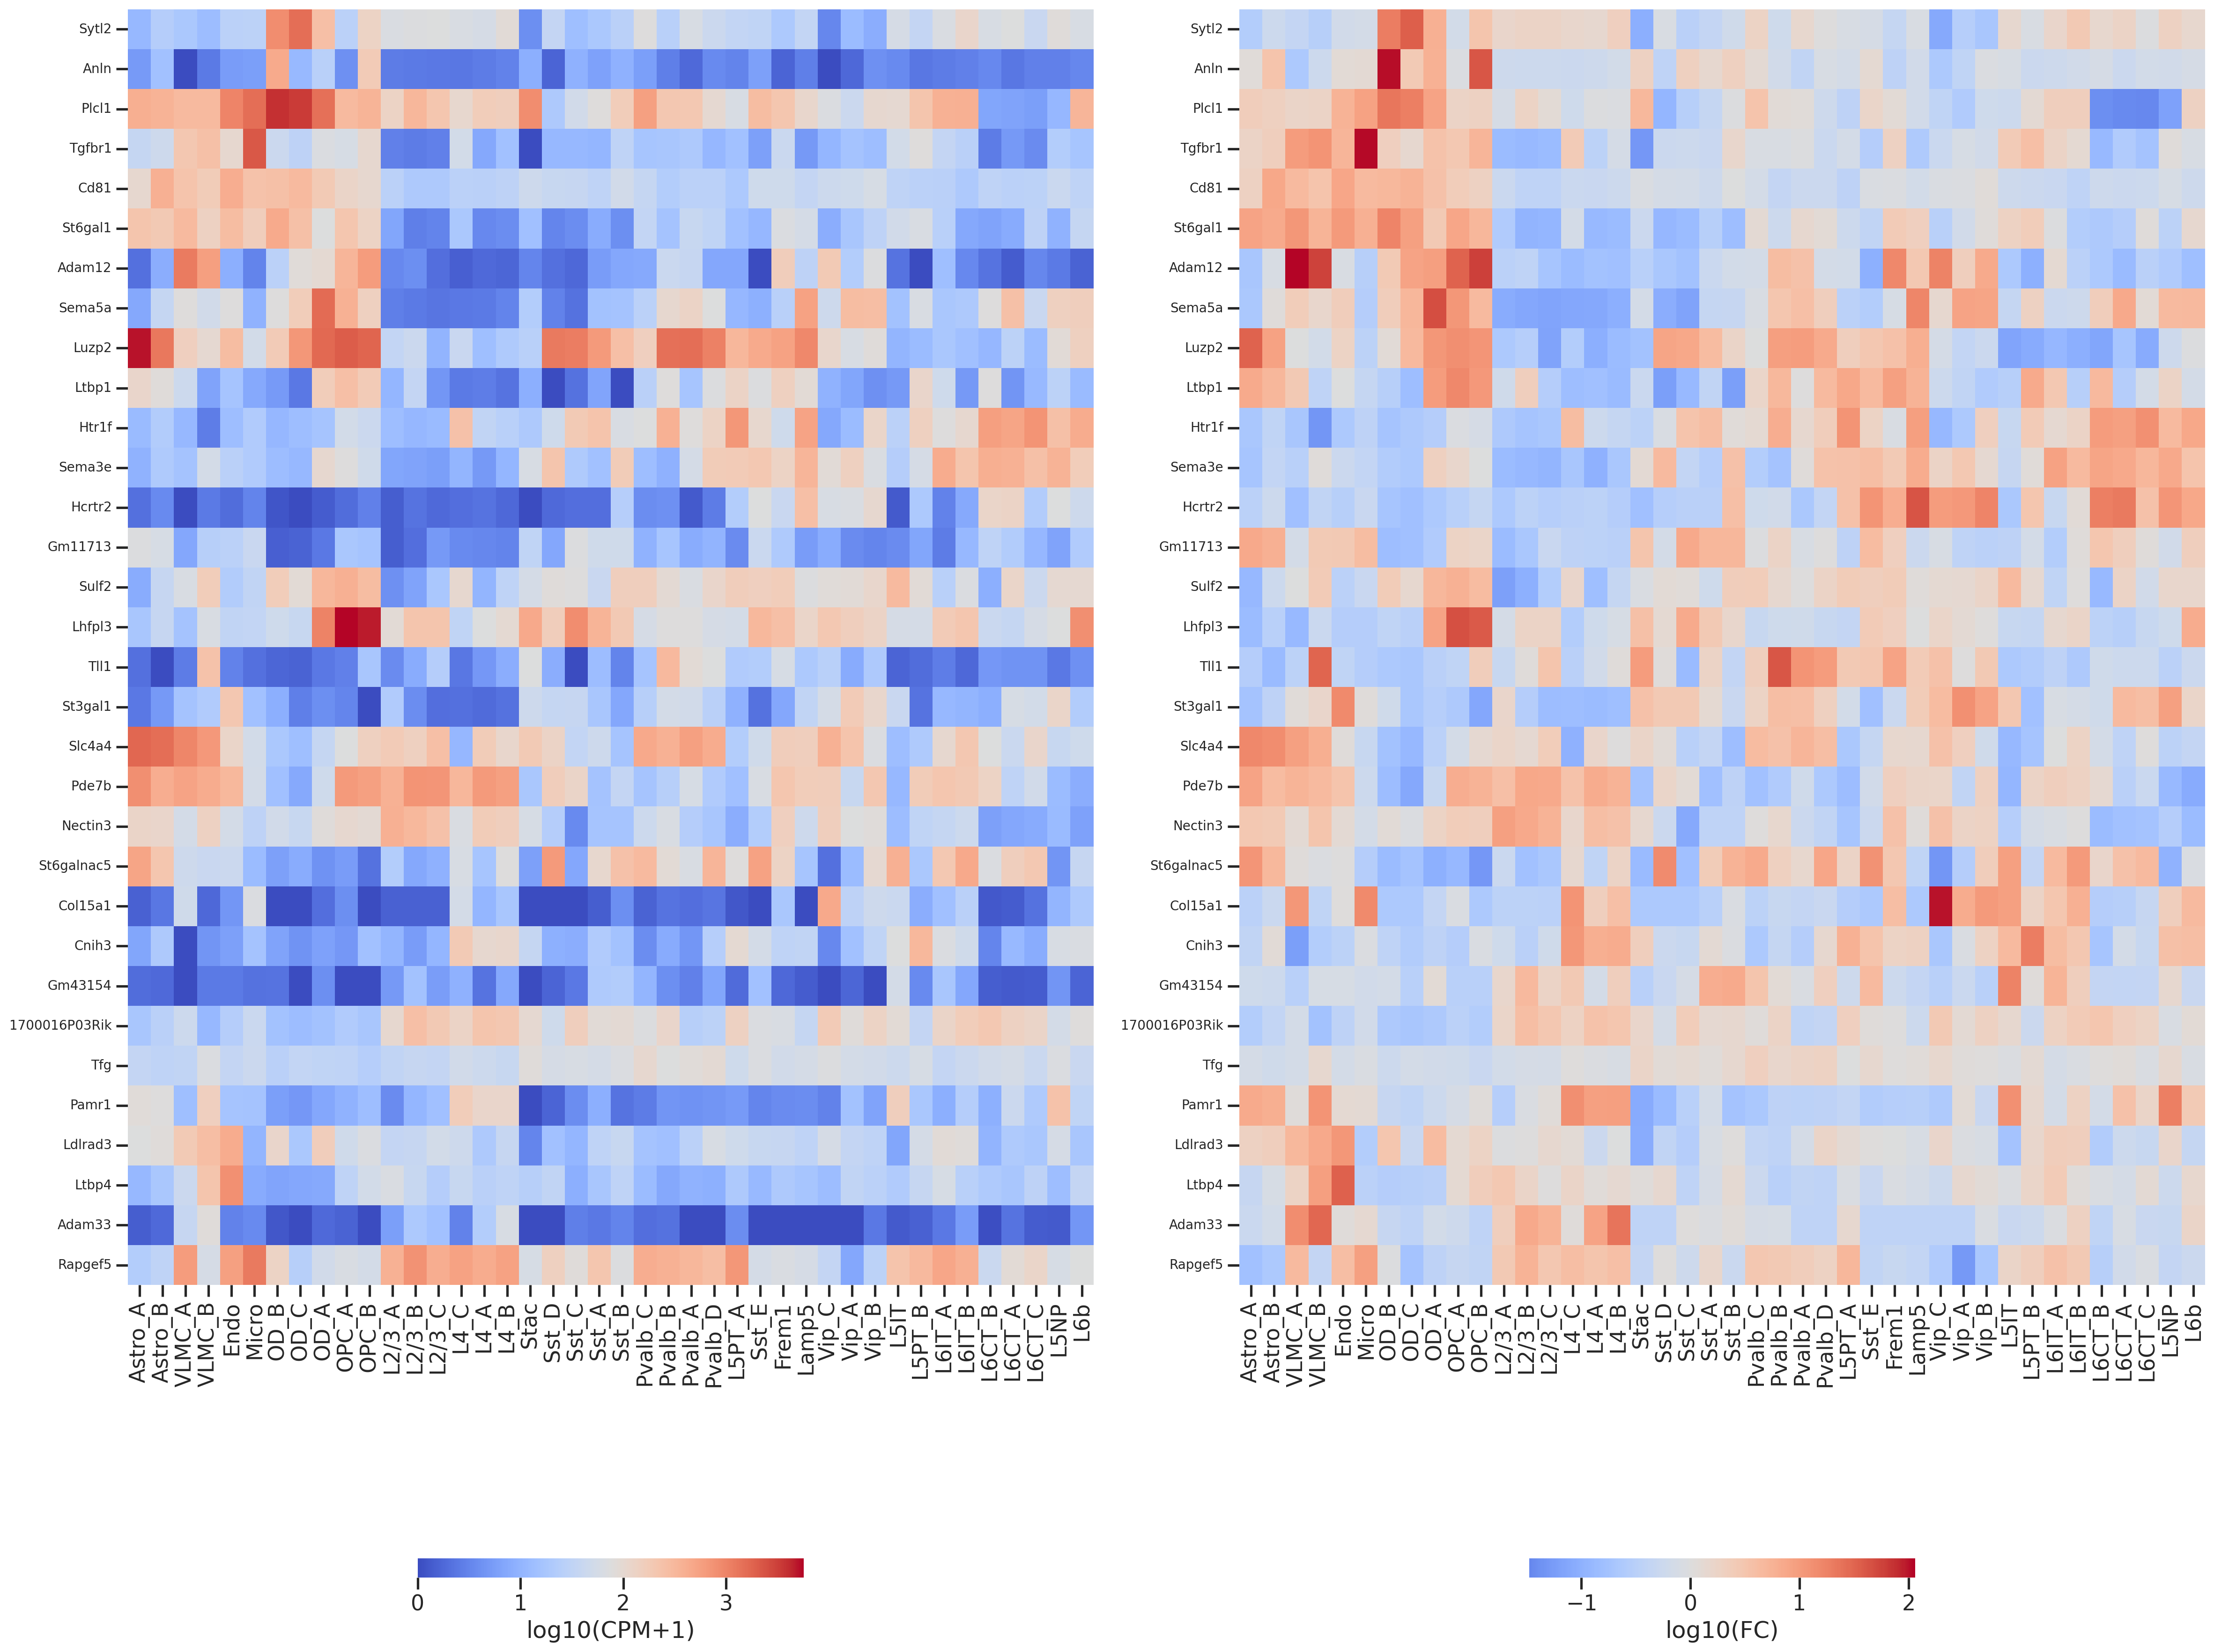

In [38]:
fig, axs = plt.subplots(1,2,figsize=(12*2,20))
ax = axs[0]
sns.heatmap(
    exp[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(CPM+1)', location='bottom'),
    # vmax=3,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax = axs[1]
sns.heatmap(
    lfc[rowidx,:][:,colidx],
    yticklabels=cnddts[rowidx],
    xticklabels=xclsts_short[colidx],
    cmap='coolwarm',
    cbar_kws=dict(shrink=0.4, label='log10(FC)', location='bottom'),
    center=0,
    ax=ax,
    )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
fig.tight_layout()
plt.show()